In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_forecast_component
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.0f}'.format)

In [2]:
# importing the data

sales_data = pd.read_csv('cleaned_sales_data.csv')
prod_prices = pd.read_csv('Producer_Prices.csv')
mat_prices = pd.read_csv('Prices_of_Materials.csv')
prod_index = pd.read_csv('Production_Index.csv')
prod_ship = pd.read_csv('Production_Shipments.csv')
clean_market_data = pd.read_csv('total_market_data_with_forecasts.csv')

In [3]:
# Merging the market data using the date

market_data = pd.merge(prod_prices, mat_prices, on='date', how='outer')
market_data = pd.merge(market_data, prod_index, on='date', how='outer')
market_data = pd.merge(market_data, prod_ship, on='date', how='outer')

In [4]:
market_data.tail()

date  PRI27840_org  PRI27826_org  PRI27380_org  PRI27250_org  \
214  2021-12-01           129           NaN           113           108   
215  2022-01-01           132           NaN           115           111   
216  2022-02-01           133           NaN           116           112   
217  2022-03-01           136           NaN           117           112   
218  2022-04-01           138           NaN           118           113   

     PRI27276_org  PRI27156_org  RohiBASEMET1000_org  RohiENERGY1000_org  \
214           116            98                  125                 112   
215           118            98                  133                 121   
216           119            99                  139                 131   
217           120            99                  150                 163   
218           121            99                  146                 153   

     RohiMETMIN1000_org  RohiNATGAS1000_org  RohCRUDE_PETRO1000_org  \
214                 117                 236                      92   
215                 125                 197                     106   
216                 131                 198                     118   
217                 141                 271                     142   
218                 138                 243                     131   

     RohCOPPER1000_org  WKLWEUR840_org  PRO28840_org  PRO281000_org  \
214                127               1           106            135   
215                130               1           111            117   
216                132               1           117            125   
217                136               1           119            149   
218                135               1           119            128   

     PRO28756_org  PRO28826_org  PRO28380_org  PRO28392_org  PRO28250_org  \
214           102            90           103           137           113   
215           100            85            92           118            91   
216            98            89           113           125            98   
217            96           109           134           161           115   
218           NaN            85           111           120            92   

     PRO28276_org  PRO27840_org  PRO271000_org  PRO27756_org  PRO27826_org  \
214           129           110            132           114           121   
215            92           111            122           109           112   
216           103           115            127           104           116   
217           122           115            152            98           145   
218            99           112            135           NaN           114   

     PRO27380_org  PRO27392_org  PRO27250_org  PRO27276_org  MAB_ELE_PRO156  \
214            73           109            81            98             311   
215            74            95            78            99             236   
216            91           104            79           106             236   
217           102           134            97           120             329   
218            86           102            81           101             267   

     MAB_ELE_SHP156  MAB_ELE_PRO250  MAB_ELE_SHP250  MAB_ELE_PRO276  \
214             311             101             135             118   
215             236              86             108              95   
216             236              91             118             104   
217             329             108             137             121   
218             267              88             117             100   

     MAB_ELE_SHP276  MAB_ELE_PRO380  MAB_ELE_SHP380  MAB_ELE_PRO392  \
214             149              94             150             128   
215             120              87             101             110   
216             129             107             121             118   
217             151             125             154             152   
218             127             104             129         

In [5]:
sales_data.sample(5)

Mapped_GCK  Sales_EUR        date
8175         #4          0  2018-12-07
7857         #5       -254  2021-03-05
231          #1    -226732  2018-12-04
5715        #13          0  2018-12-19
2893         #4          0  2019-04-17

In [6]:
sales_data.dtypes

Mapped_GCK     object
Sales_EUR     float64
date           object
dtype: object

In [7]:
sales_data['date'] = pd.to_datetime(sales_data['date'])

sales_data['YearMonth'] = sales_data['date'].dt.to_period('M')

# Step 2: Aggregate total revenue per product per month
monthly_revenue = sales_data.groupby(['Mapped_GCK', 'YearMonth'])['Sales_EUR'].sum().reset_index()

# Step 3: Convert 'YearMonth' to the first day of the month ('YYYY-MM-01')
monthly_revenue['date'] = monthly_revenue['YearMonth'].dt.to_timestamp()

# Drop 'YearMonth' if it's no longer needed
sales_data = monthly_revenue.drop(columns=['YearMonth'])

In [8]:
sales_data.shape

(602, 3)

In [9]:
sales_data.sample(5)

Mapped_GCK  Sales_EUR       date
142        #13      43191 2019-11-01
405         #4     521506 2020-04-01
583         #9      39511 2020-10-01
443         #5    8243672 2019-11-01
576         #9       3605 2020-03-01

In [10]:
clean_market_data['date'] = pd.to_datetime(clean_market_data['date'])

# Encoding

In [11]:
# Ensure 'Date_my' is in datetime format for both datasets
market_data['date'] = pd.to_datetime(market_data['date'])

# Merge sales data with market index data on 
df = sales_data.merge(clean_market_data, on='date', how='left')

In [12]:
encoder = LabelEncoder()

# Fit and transform the data
encoded_data = encoder.fit_transform(df['Mapped_GCK'])

df['Mapped_GCK'] = encoded_data


In [13]:
df['DaysSinceStart'] = (df['date'] - df['date'].min()).dt.days

In [14]:
# # lets use the standardization method to scale the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# # Fit and transform the data
# scaled_data = scaler.fit_transform(df)  

# Feature Selection

In [15]:
# Extract time-based features
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

# Dictionary to store top features per product
top_features_dict = {}

In [16]:
df['Mapped_GCK'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [17]:
df_train =df[df['date'] < '2021-05-01']
df_test = df[df['date'] >= '2021-05-01']

RFE

## XGBoost

In [18]:

top_features_per_product = {}

# Loop through each unique product
for product in df['Mapped_GCK'].unique():
    product_df = df[df['Mapped_GCK'] == product]
    df_train =product_df[product_df['date'] < '2021-05-01']
    df_test = product_df[product_df['date'] >= '2021-05-01']
    X_train = df_train.drop(columns=['date','Mapped_GCK' ,'Sales_EUR' , 'Year' , 'Month', 'DaysSinceStart'])
    y_train = df_train['Sales_EUR']
    X_test = df_test.drop(columns=['date','Mapped_GCK' ,'Sales_EUR' , 'Year' , 'Month'])
    y_test = df_test['Sales_EUR']
# Train XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric="rmse", n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
# Get feature importances
    feature_importance = model.feature_importances_
    feature_names = X_train.columns
    
    top_features = feature_names[feature_importance.argsort()[-5:][::-1]]

    # Store results
    top_features_per_product[product] = top_features.tolist()


In [19]:
top_features_df = pd.DataFrame.from_dict(top_features_per_product, orient='index')

In [20]:
top_features_df

0                    1                       2  \
0        MAB_ELE_PRO276      MAB_ELE_SHP1100            PRO27826_org   
1          PRO28756_org         PRI27276_org          MAB_ELE_SHP250   
2          PRO28392_org         PRI27276_org            PRI27156_org   
3          PRO27250_org        PRO281000_org            PRI27156_org   
4   RohiBASEMET1000_org       MAB_ELE_PRO840           PRO271000_org   
5        MAB_ELE_SHP276       MAB_ELE_PRO756            PRI27156_org   
6   RohiBASEMET1000_org         PRO27392_org          MAB_ELE_SHP250   
7          PRO27826_org       MAB_ELE_SHP380  RohCRUDE_PETRO1000_org   
8        MAB_ELE_PRO840       MAB_ELE_PRO756      RohiENERGY1000_org   
9          PRO27276_org  RohiBASEMET1000_org            PRI27380_org   
10         PRI27156_org       MAB_ELE_PRO840          MAB_ELE_SHP392   
11         PRO28380_org         PRO27276_org            PRO28840_org   
12       WKLWEUR840_org       MAB_ELE_SHP840           PRO281000_org   
13       MAB_ELE_PRO380       MAB_ELE_SHP392            PRO28250_org   

                      3                   4  
0        MAB_ELE_SHP840        PRO27756_org  
1    RohiENERGY1000_org  RohiMETMIN1000_org  
2        MAB_ELE_PRO756      WKLWEUR840_org  
3          PRI27250_org      MAB_ELE_SHP276  
4          PRI27840_org      MAB_ELE_PRO756  
5    RohiENERGY1000_org      MAB_ELE_SHP826  
6        MAB_ELE_PRO250        PRO27826_org  
7   RohiBASEMET1000_org        PRI27380_org  
8         PRO281000_org        PRI27156_org  
9          PRO27392_org      MAB_ELE_PRO840  
10       MAB_ELE_SHP276      MAB_ELE_SHP840  
11      MAB_ELE_PRO1100      MAB_ELE_SHP380  
12       MAB_ELE_PRO392        PRO27826_org  
13        PRO271000_org      MAB_ELE_SHP826

In [21]:
# Filtering the features
df_model = df.copy()

In [22]:
df_model['ds'] = df_model['date']
df_model['y'] = df_model['Sales_EUR']

# Splitting the data with the date criteria. being train with dates before 04-2021 and test with dates after 04-2021
X_train = df_model[df_model['date'] < '2021-05-01']
X_test = df_model[df_model['date'] >= '2021-05-01']

# Models

In [23]:
rmse_results = {}

## Prophet

Prophet without features

In [24]:
forecasts = {}

In [25]:
# forecasts = {}

# plt.figure(figsize=(12, 6))  # Create a single figure

# # Loop over each unique product ID
# for product in X_train['Mapped_GCK'].unique():

#     train_data = X_train[X_train['Mapped_GCK'] == product]
#     test_data = X_test[X_test['Mapped_GCK'] == product]
#     train_data['floor'] = 0
#     train_data['cap'] = train_data['y'].max() * 1.5

#     # Initialize Prophet model
#     model = Prophet(growth='logistic')
    
#     # Fit the model on training data
#     model.fit(train_data)

#     # Create future dataframe using test data
#     future = test_data[['ds']].copy()
#     for feature in features_model:
#         future[feature] = test_data[feature].values  # Ensure alignment
#         future['floor'] = 0
#         future['cap'] = train_data['y'].max() * 1.5

#     # Predict sales
#     forecast = model.predict(future)
#     forecasts[product] = forecast  # Store results

#     # Plot each product's forecast on the same figure
#     plt.plot(forecast['ds'], forecast['yhat'], label=f'Product {product}')

# # Finalize the global plot
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.title('Global Sales Forecast for All Products')
# plt.legend()  # Show product labels
# plt.show()

18:14:40 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 0


18:14:40 - cmdstanpy - INFO - Chain [1] done processing


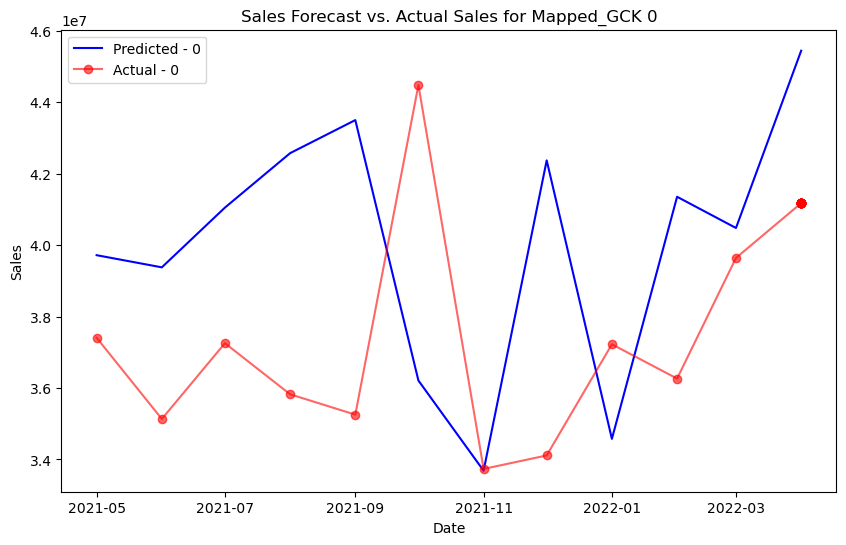

18:14:40 - cmdstanpy - INFO - Chain [1] start processing
18:14:40 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 1


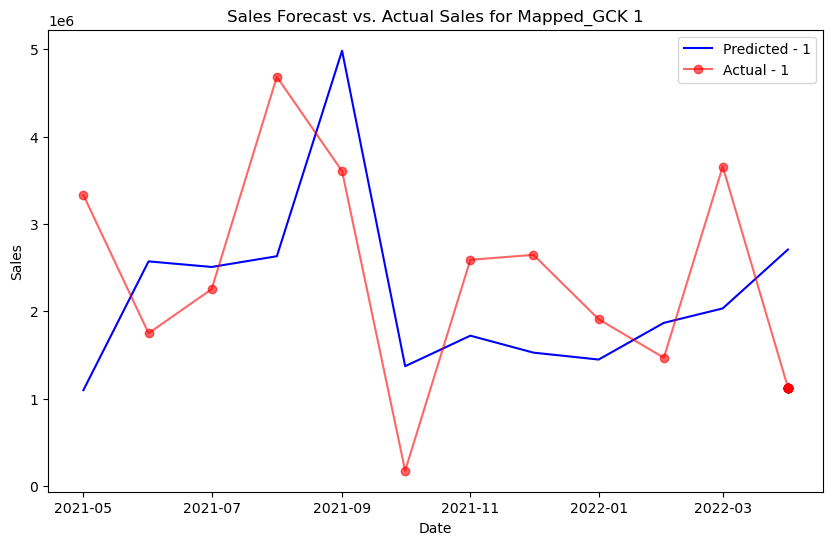

18:14:41 - cmdstanpy - INFO - Chain [1] start processing
18:14:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 2


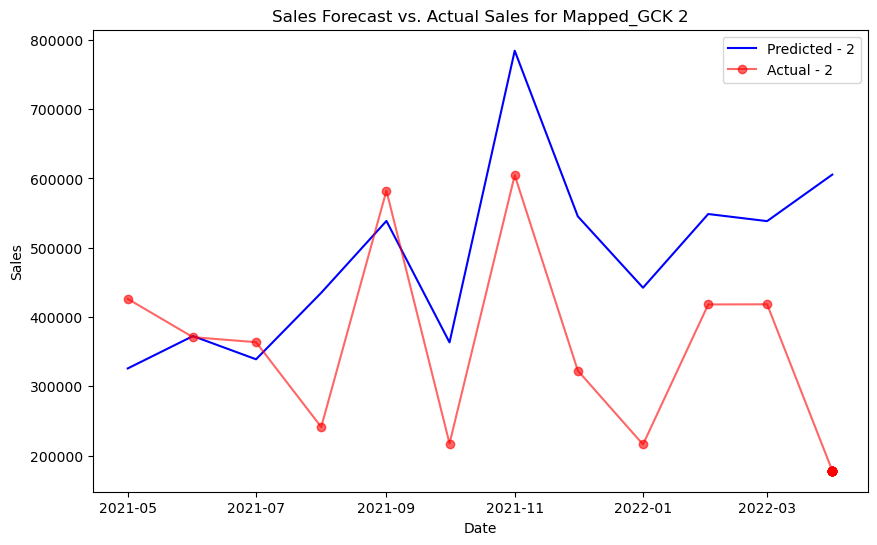

18:14:41 - cmdstanpy - INFO - Chain [1] start processing
18:14:41 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 3


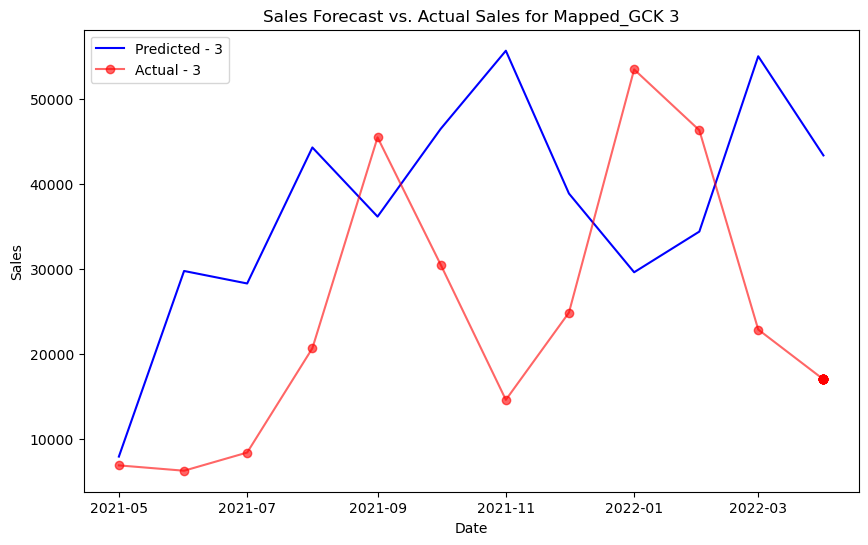

18:14:41 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 4


18:14:41 - cmdstanpy - INFO - Chain [1] done processing


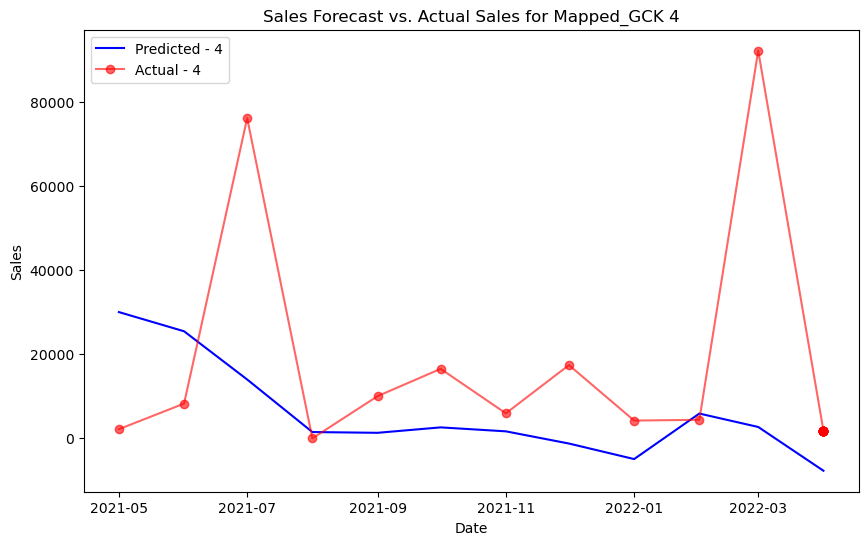

18:14:42 - cmdstanpy - INFO - Chain [1] start processing
18:14:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 5


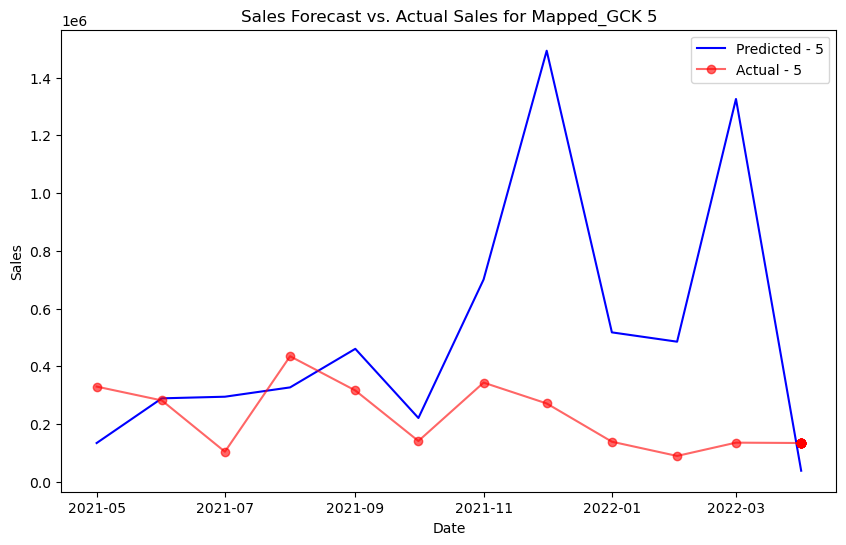

18:14:42 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 6


18:14:42 - cmdstanpy - INFO - Chain [1] done processing


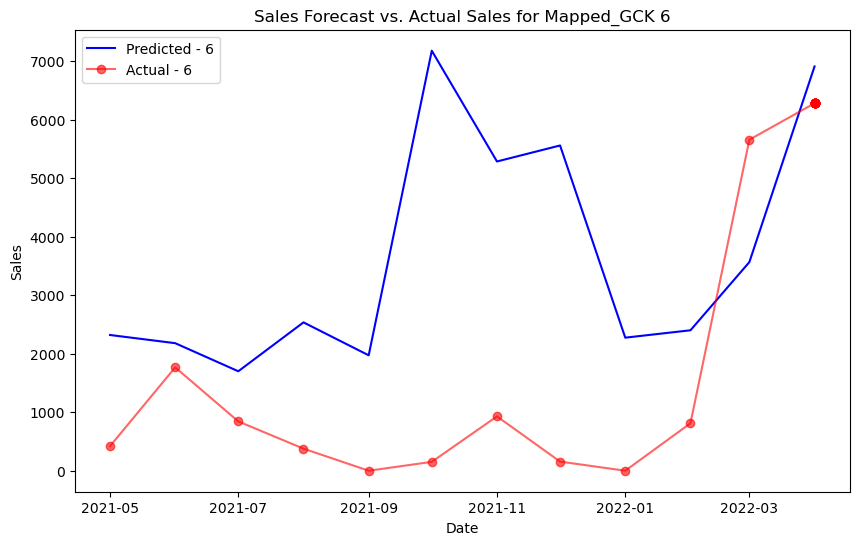

18:14:42 - cmdstanpy - INFO - Chain [1] start processing
18:14:42 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 7


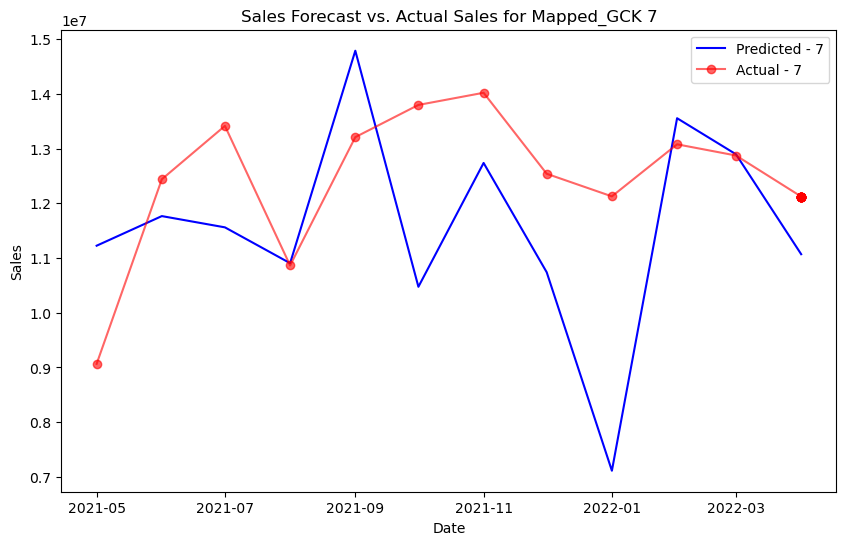

18:14:43 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 8


18:14:43 - cmdstanpy - INFO - Chain [1] done processing


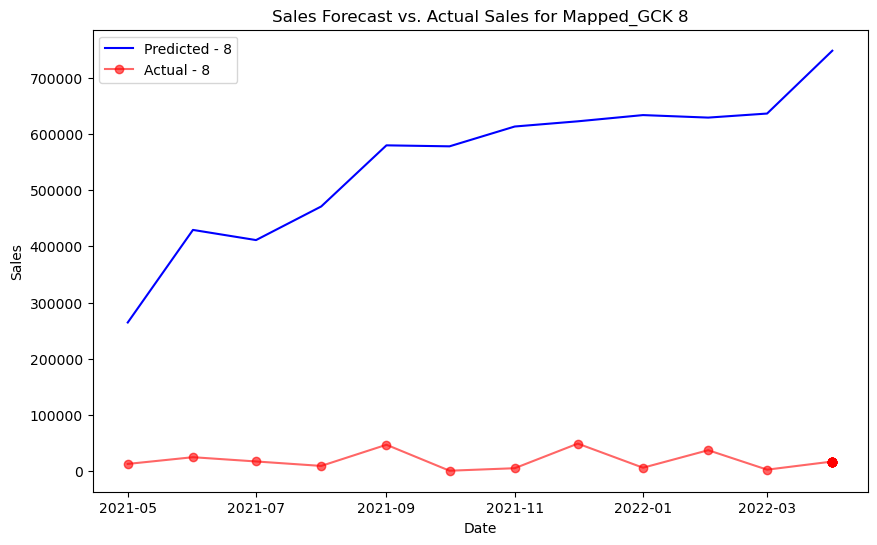

18:14:43 - cmdstanpy - INFO - Chain [1] start processing
18:14:43 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 9


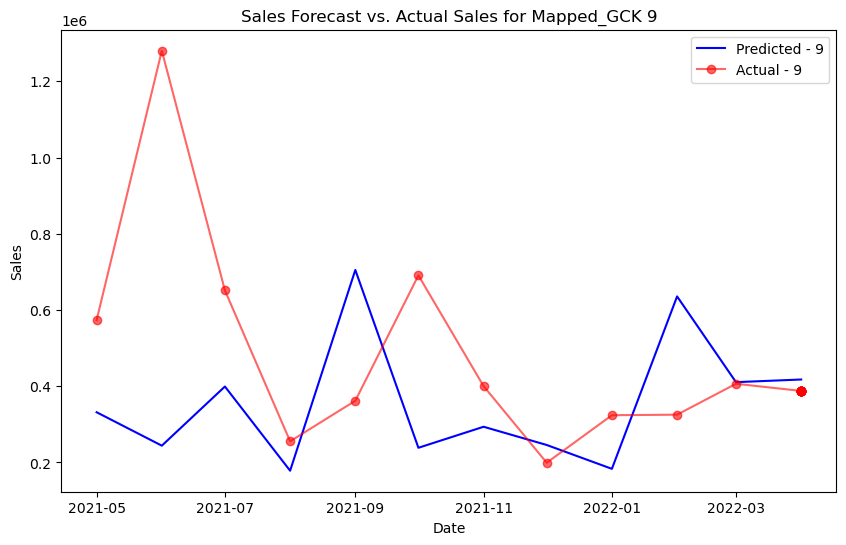

18:14:43 - cmdstanpy - INFO - Chain [1] start processing
18:14:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 10


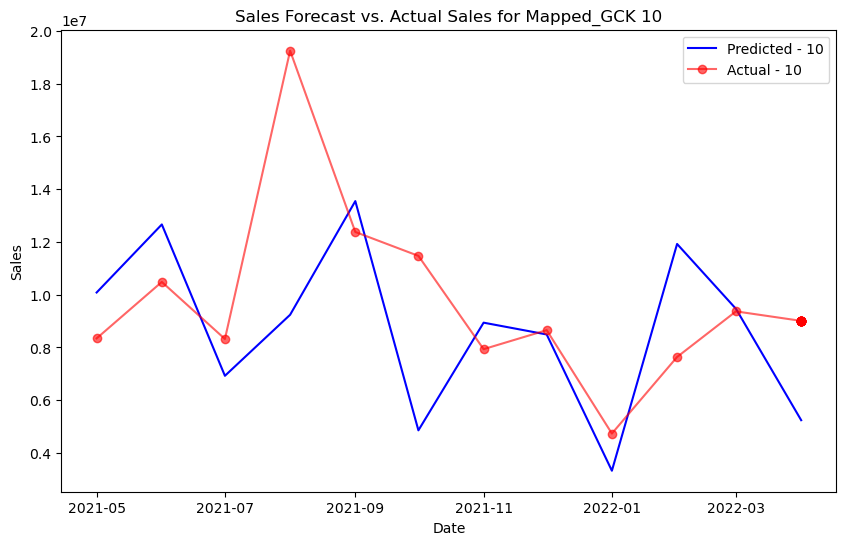

18:14:44 - cmdstanpy - INFO - Chain [1] start processing
18:14:44 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 11


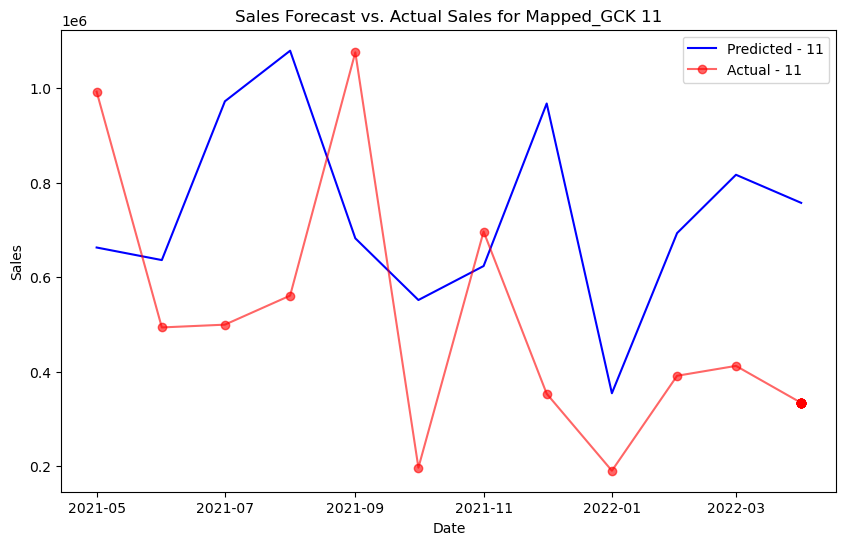

18:14:44 - cmdstanpy - INFO - Chain [1] start processing


Training model for Mapped_GCK: 12


18:14:44 - cmdstanpy - INFO - Chain [1] done processing


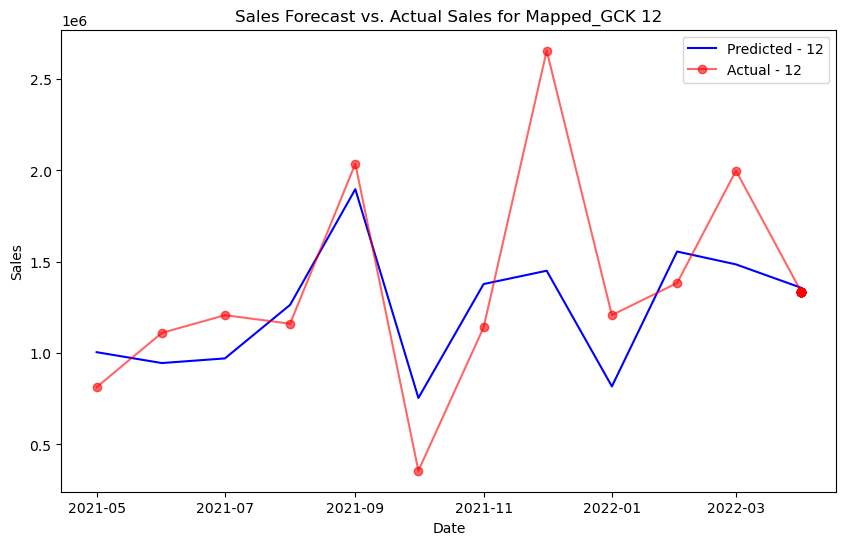

18:14:44 - cmdstanpy - INFO - Chain [1] start processing
18:14:45 - cmdstanpy - INFO - Chain [1] done processing


Training model for Mapped_GCK: 13


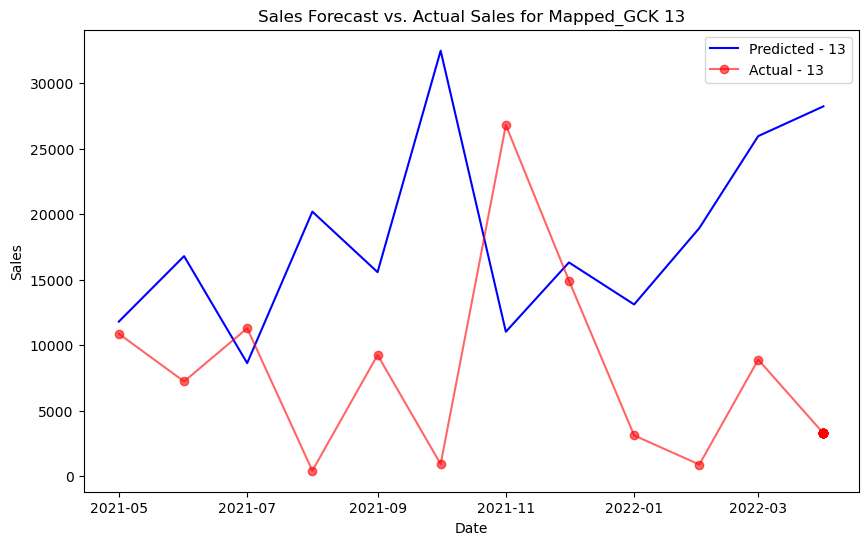

In [26]:
model_name = 'Prophet_vanila'

# Loop over each unique Mapped_GCK
for product in X_train['Mapped_GCK'].unique():
    print(f"Training model for Mapped_GCK: {product}")

    # Filter data for the current Mapped_GCK
    train_data = X_train[X_train['Mapped_GCK'] == product]
    test_data = X_test[X_test['Mapped_GCK'] == product]
    train_data['floor'] = 0
    train_data['cap'] = train_data['y'].max() * 1.5
    

    # Initialize Prophet model
    model = Prophet(growth='logistic')

    # Fit the model on training data
    model.fit(train_data)

    # Create future dataframe using test data
    future = test_data[['ds']].copy()
    future['floor'] = 0
    future['cap'] = train_data['y'].max() * 1.5

    # Predict sales
    forecast = model.predict(future)
    forecasts[product] = forecast  # Store results

    # Compute RMSE
    rmse = root_mean_squared_error(test_data['y'], forecast['yhat'])

    # Store RMSE in dictionary
    if product not in rmse_results:
        rmse_results[product] = {}  # Create entry if not exists
    rmse_results[product][model_name] = rmse  # Store RMSE for this model

    # Create a new figure for each product
    plt.figure(figsize=(10, 6))
    
    # Plot forecasted sales (yhat)
    plt.plot(forecast['ds'], forecast['yhat'], label=f'Predicted - {product}', color='blue')

    # Plot actual sales (from test data)
    plt.plot(test_data['ds'], test_data['y'], alpha=0.6, marker='o', label=f'Actual - {product}', color='red')

    # Finalize the plot
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecast vs. Actual Sales for Mapped_GCK {product}')
    plt.legend()
    plt.show()

# Convert dictionary to DataFrame
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index')

In [27]:
# for product in X_train['Mapped_GCK'].unique():
    
#     plt.plot(forecast['ds'], forecast['yhat'], label=f'Product {product}')

# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.title('Global Sales Forecast for All Products')
# plt.legend()  # Show product labels
# plt.show()

Prophet with features

18:14:45 - cmdstanpy - INFO - Chain [1] start processing
18:14:45 - cmdstanpy - INFO - Chain [1] done processing


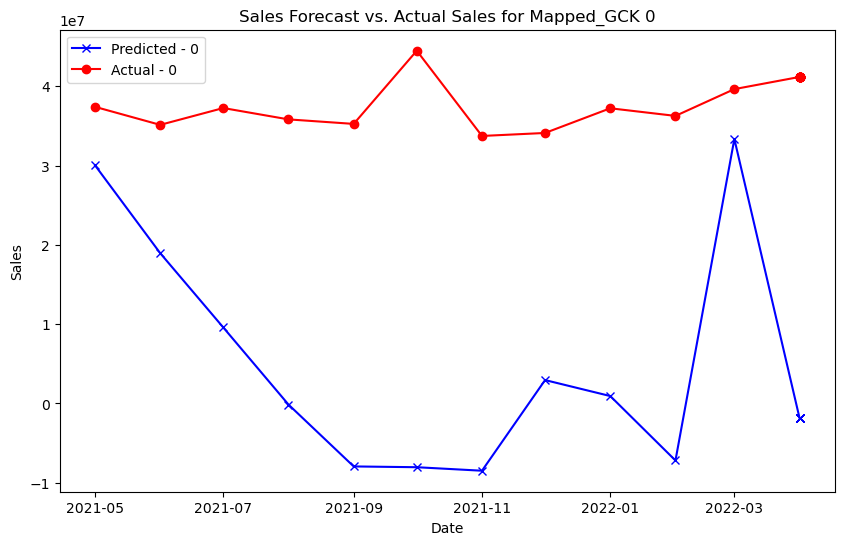

18:14:45 - cmdstanpy - INFO - Chain [1] start processing
18:14:45 - cmdstanpy - INFO - Chain [1] done processing


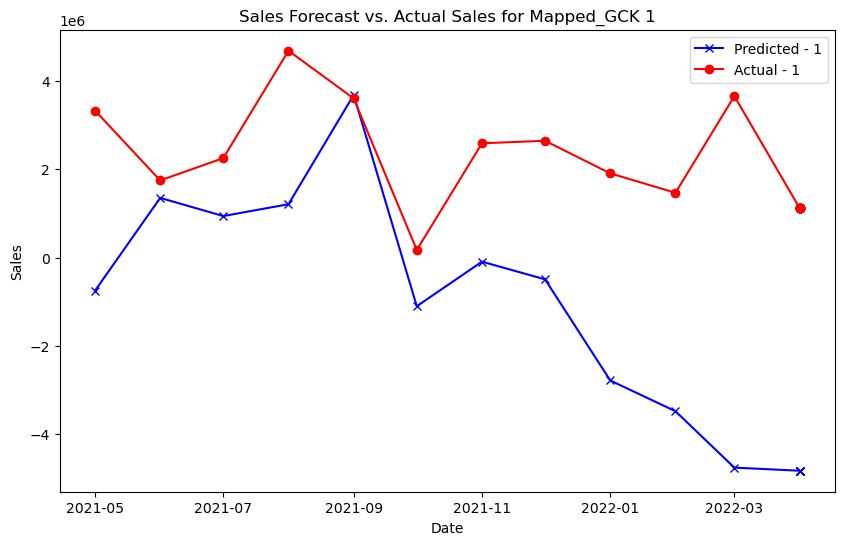

18:14:46 - cmdstanpy - INFO - Chain [1] start processing
18:14:46 - cmdstanpy - INFO - Chain [1] done processing


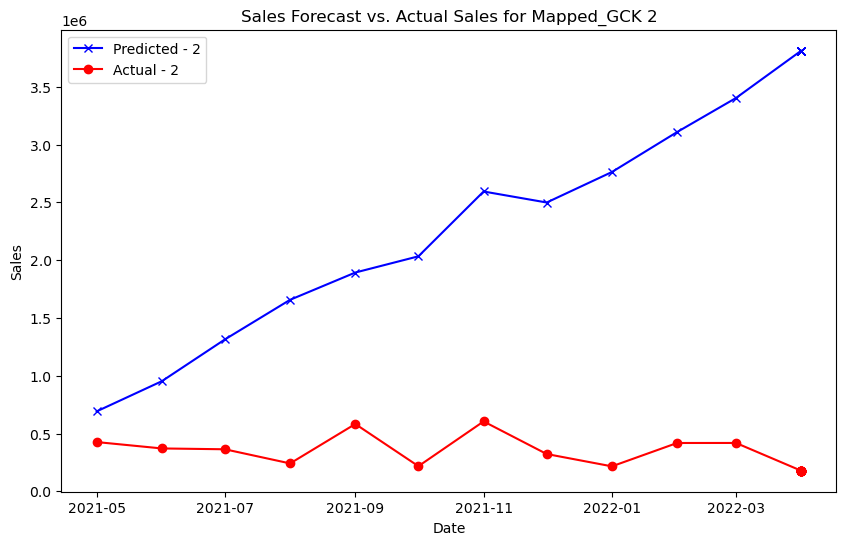

18:14:46 - cmdstanpy - INFO - Chain [1] start processing
18:14:46 - cmdstanpy - INFO - Chain [1] done processing


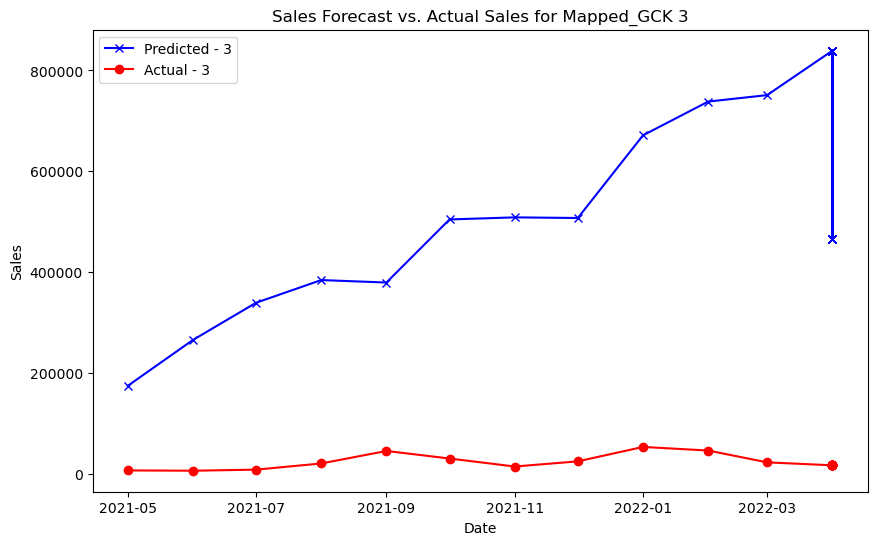

18:14:46 - cmdstanpy - INFO - Chain [1] start processing
18:14:47 - cmdstanpy - INFO - Chain [1] done processing


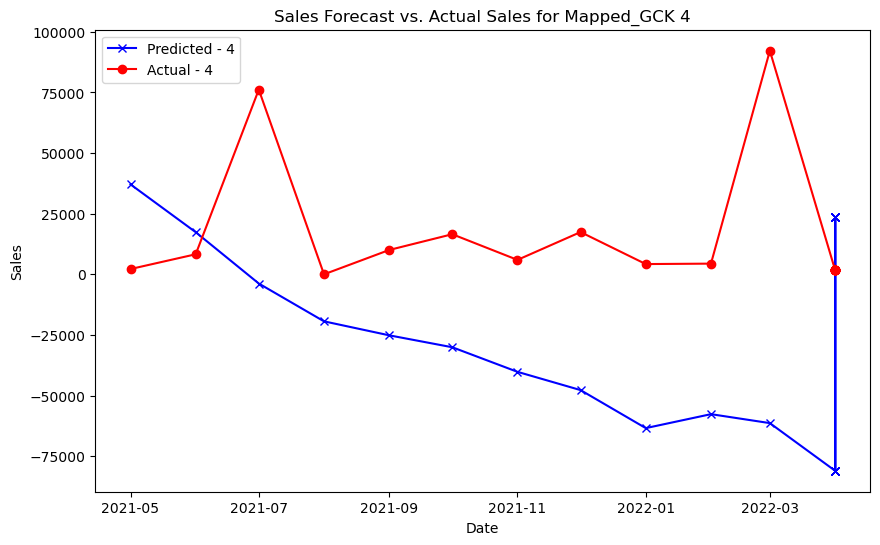

18:14:47 - cmdstanpy - INFO - Chain [1] start processing
18:14:47 - cmdstanpy - INFO - Chain [1] done processing


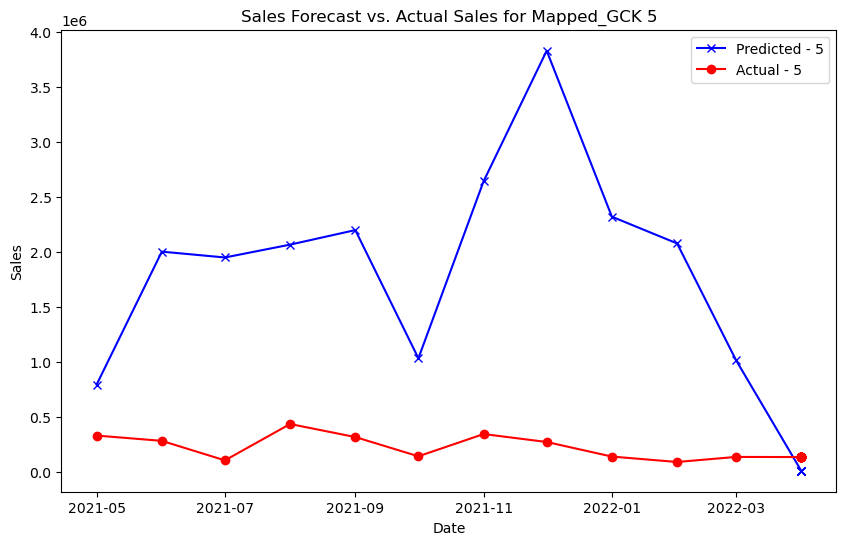

18:14:47 - cmdstanpy - INFO - Chain [1] start processing
18:14:47 - cmdstanpy - INFO - Chain [1] done processing


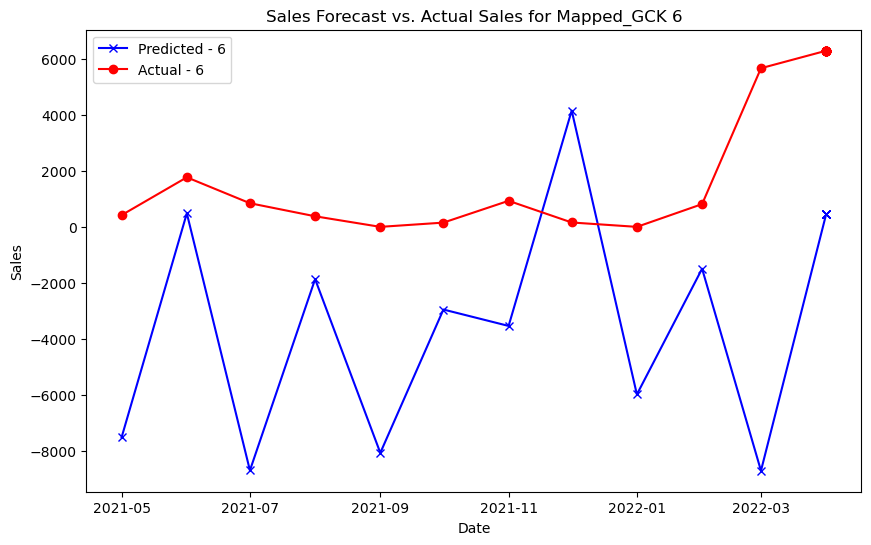

18:14:48 - cmdstanpy - INFO - Chain [1] start processing
18:14:48 - cmdstanpy - INFO - Chain [1] done processing


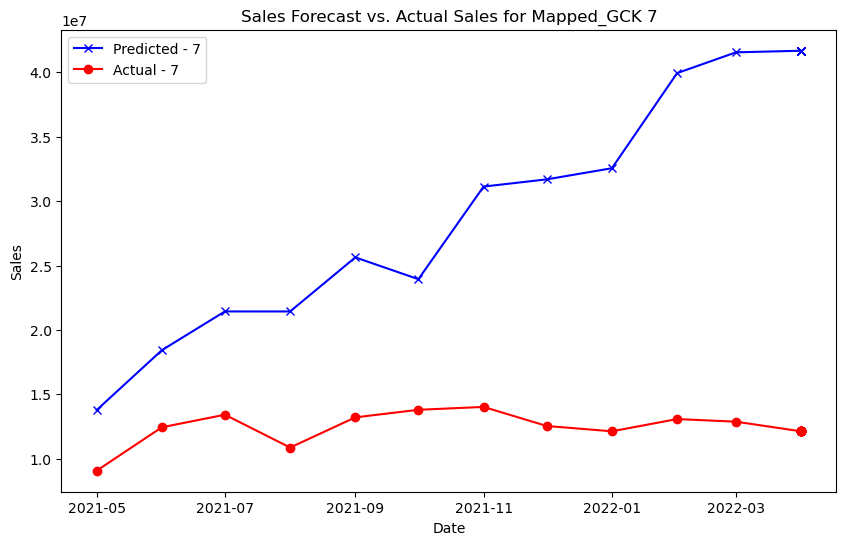

18:14:48 - cmdstanpy - INFO - Chain [1] start processing
18:14:48 - cmdstanpy - INFO - Chain [1] done processing


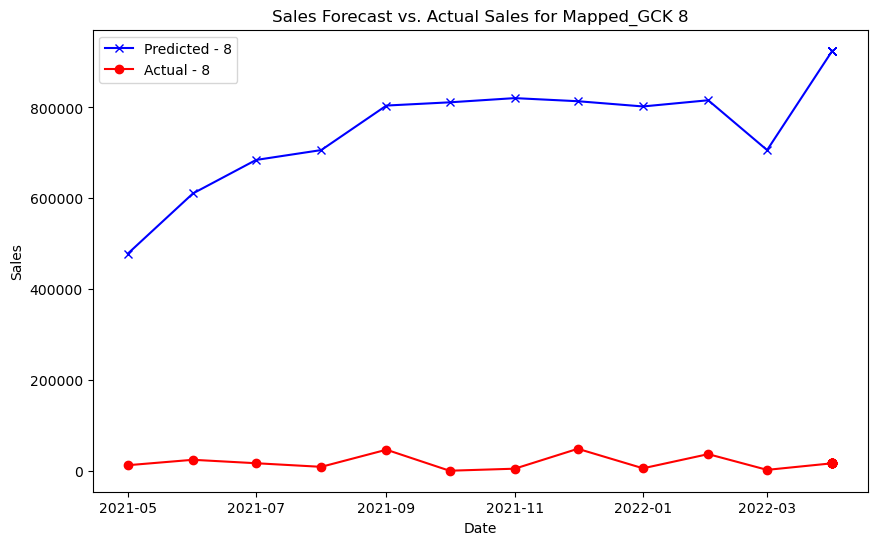

18:14:48 - cmdstanpy - INFO - Chain [1] start processing
18:14:49 - cmdstanpy - INFO - Chain [1] done processing


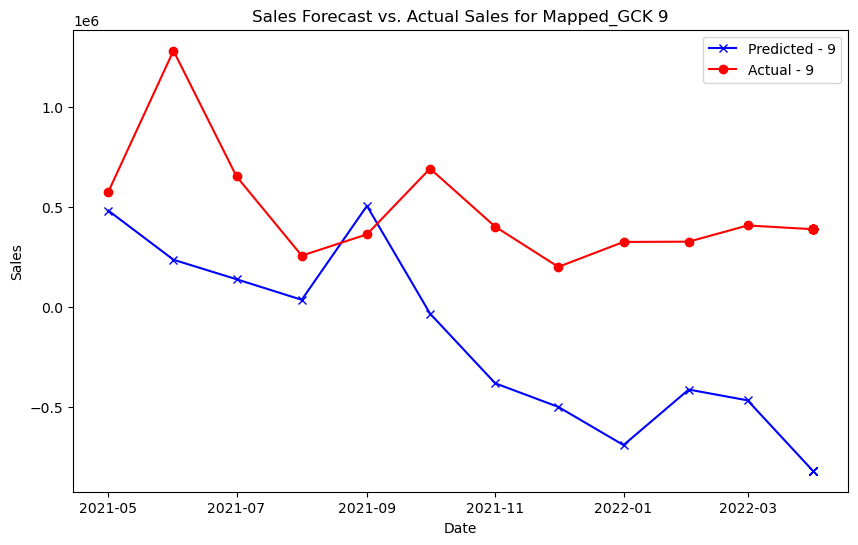

18:14:49 - cmdstanpy - INFO - Chain [1] start processing
18:14:49 - cmdstanpy - INFO - Chain [1] done processing


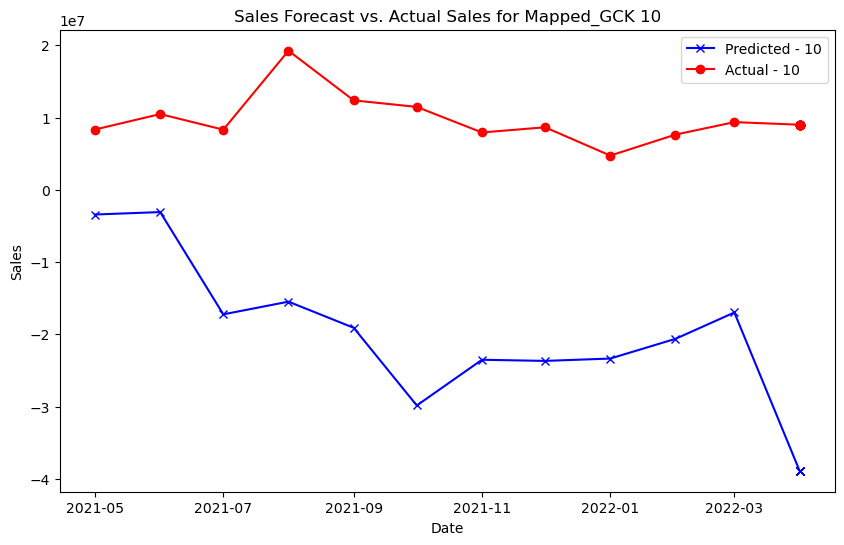

18:14:49 - cmdstanpy - INFO - Chain [1] start processing
18:14:50 - cmdstanpy - INFO - Chain [1] done processing


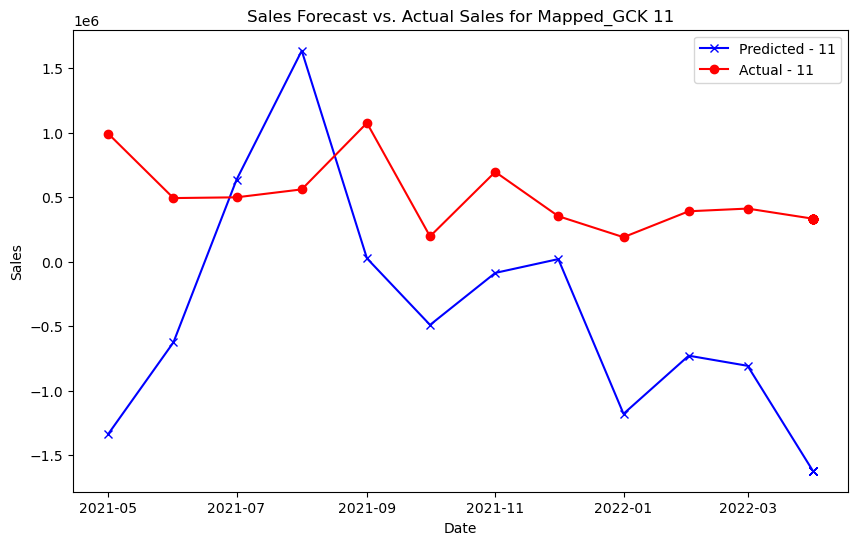

18:14:50 - cmdstanpy - INFO - Chain [1] start processing
18:14:50 - cmdstanpy - INFO - Chain [1] done processing


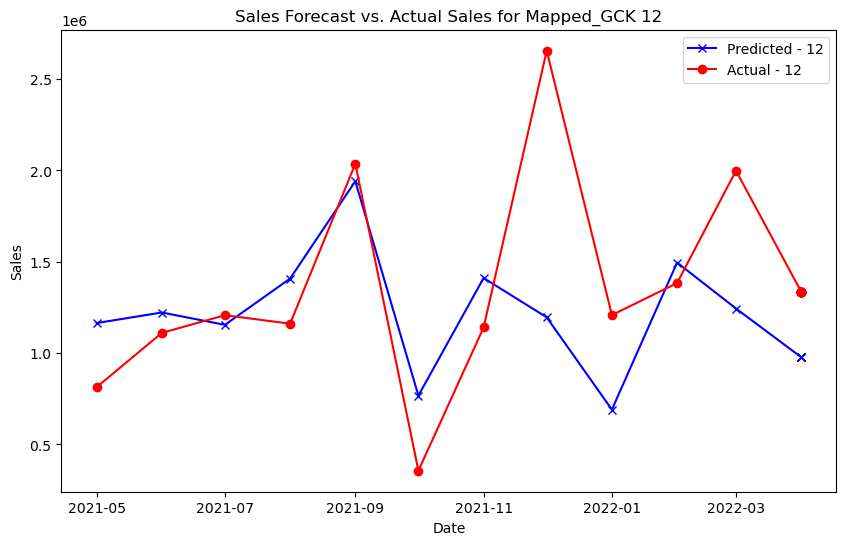

18:14:50 - cmdstanpy - INFO - Chain [1] start processing
18:14:50 - cmdstanpy - INFO - Chain [1] done processing


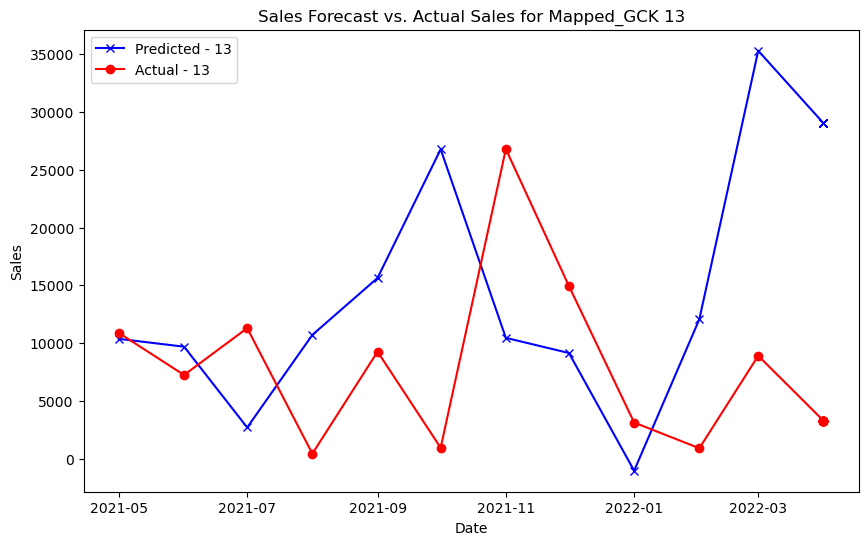

In [28]:
model_name = "Prophet_with_features"
forecasts = {}

# Loop over each unique Mapped_GCK
for product in X_train['Mapped_GCK'].unique():
    
    # Select the top 10 features for the current product
    top_features = top_features_per_product.get(product, [])  # Get saved features
    
    train_data = X_train[X_train['Mapped_GCK'] == product][['ds', 'y'] + top_features]
    test_data = X_test[X_test['Mapped_GCK'] == product][['ds', 'y'] + top_features]
    train_data[top_features] = train_data[top_features].astype(float)
    test_data[top_features] = test_data[top_features].astype(float)
    train_data['floor'] = 0.5
    train_data['cap'] = train_data['y'].max() * 1.5

    # Initialize Prophet model
    model = Prophet(growth='logistic')
    
    # Add each top feature as a regressor
    for feature in top_features:
        model.add_regressor(feature)
    
    # Fit the model on training data
    model.fit(train_data)

    # Create future dataframe using test data
    future = test_data[['ds']].copy()
    for feature in top_features:
        future[feature] = test_data[feature].values  
    future['floor'] = 0.5
    future['cap'] = train_data['y'].max() * 1.5
    
    # Predict sales
    forecast = model.predict(future)
    forecasts[product] = forecast  

    # Compute RMSE
    rmse = root_mean_squared_error(test_data['y'], forecast['yhat'])

    # Store RMSE in dictionary
    if product not in rmse_results:
        rmse_results[product] = {}  # Create entry if not exists
    rmse_results[product][model_name] = rmse  # Store RMSE for this model

    # Create a new figure for each product
    plt.figure(figsize=(10, 6))
    
    # Plot forecasted sales (yhat)
    plt.plot(forecast['ds'], forecast['yhat'], marker='x', label=f'Predicted - {product}', color='blue')

    # Plot actual sales (from test data)
    plt.plot(test_data['ds'], test_data['y'], marker='o', label=f'Actual - {product}', color='red')

    # Finalize the plot
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecast vs. Actual Sales for Mapped_GCK {product}')
    plt.legend()
    plt.show()

# Convert dictionary to DataFrame
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index')

In [29]:
rmse_results

{0: {'Prophet_vanila': 4765012.155207862,
  'Prophet_with_features': 39722658.04398702},
 1: {'Prophet_vanila': 1469030.5677702597,
  'Prophet_with_features': 5209426.855683226},
 2: {'Prophet_vanila': 342064.54343881964,
  'Prophet_with_features': 3048698.324498198},
 3: {'Prophet_vanila': 24759.261680468364,
  'Prophet_with_features': 595198.7118918371},
 4: {'Prophet_vanila': 23669.71699364573,
  'Prophet_with_features': 63394.6254593793},
 5: {'Prophet_vanila': 365113.55770673166,
  'Prophet_with_features': 1236273.1095607083},
 6: {'Prophet_vanila': 2186.0770976954177,
  'Prophet_with_features': 6266.473617511534},
 7: {'Prophet_vanila': 1611361.8425465007,
  'Prophet_with_features': 25160368.73947699},
 8: {'Prophet_vanila': 655836.5526712933,
  'Prophet_with_features': 836543.772044151},
 9: {'Prophet_vanila': 248629.69589122635,
  'Prophet_with_features': 1032164.0950728189},
 10: {'Prophet_vanila': 3864614.5255110743,
  'Prophet_with_features': 41223670.31081627},
 11: {'Proph

## XGBoost

Without features

With features

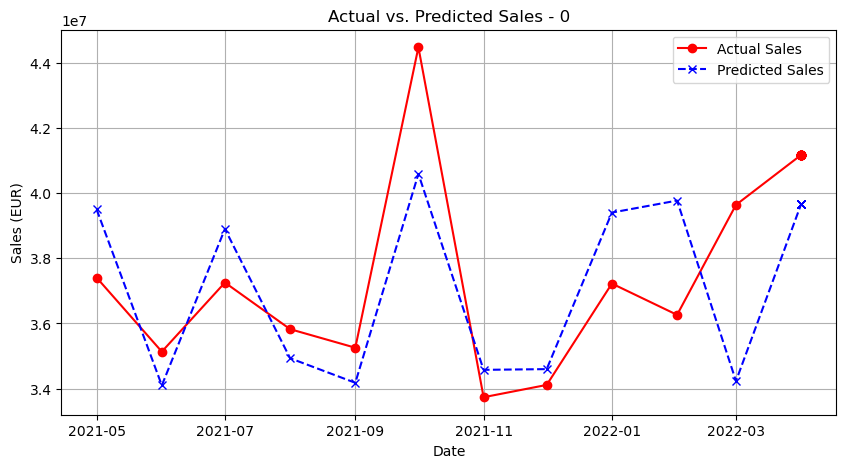

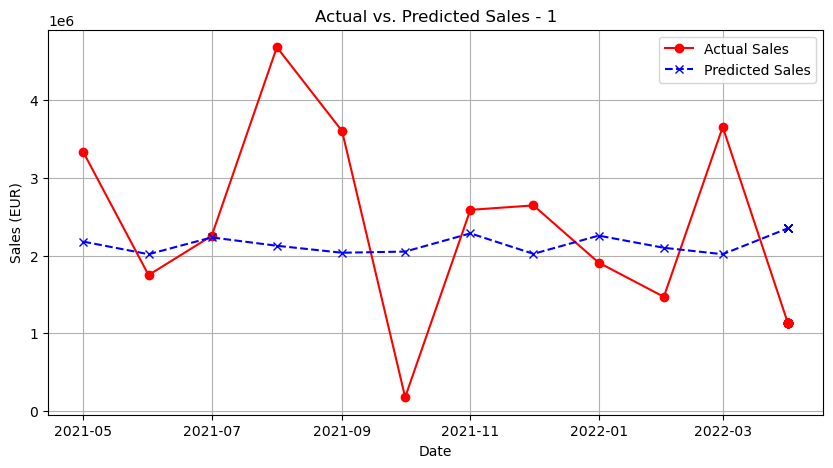

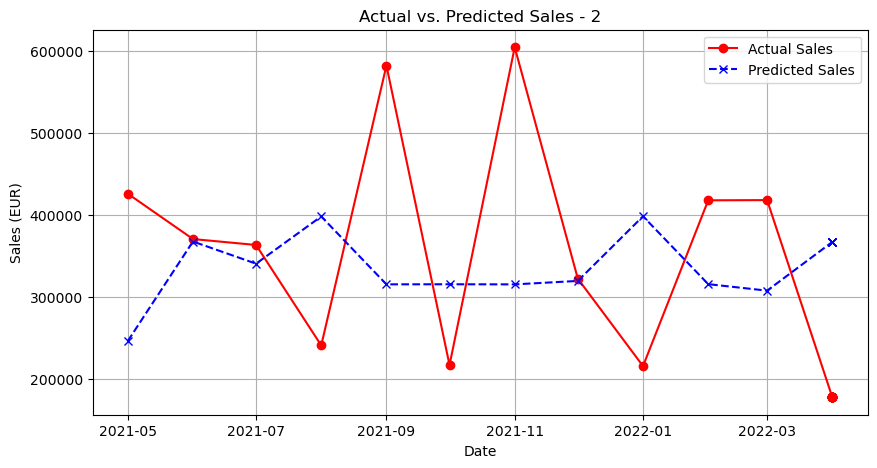

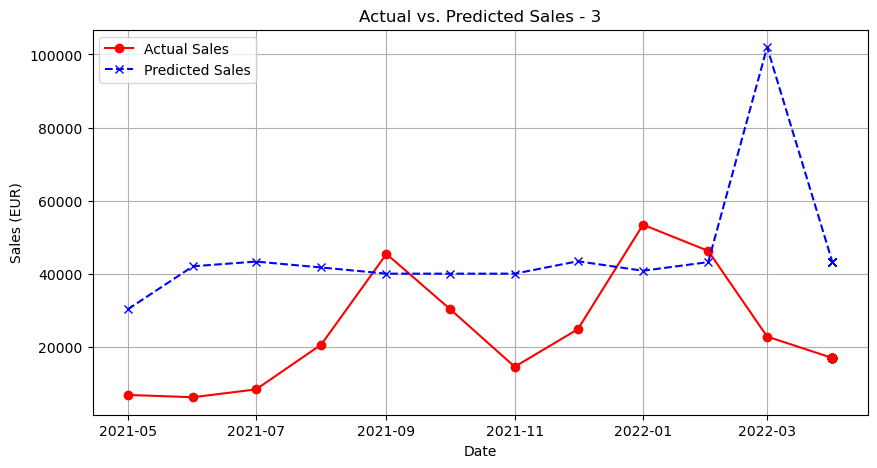

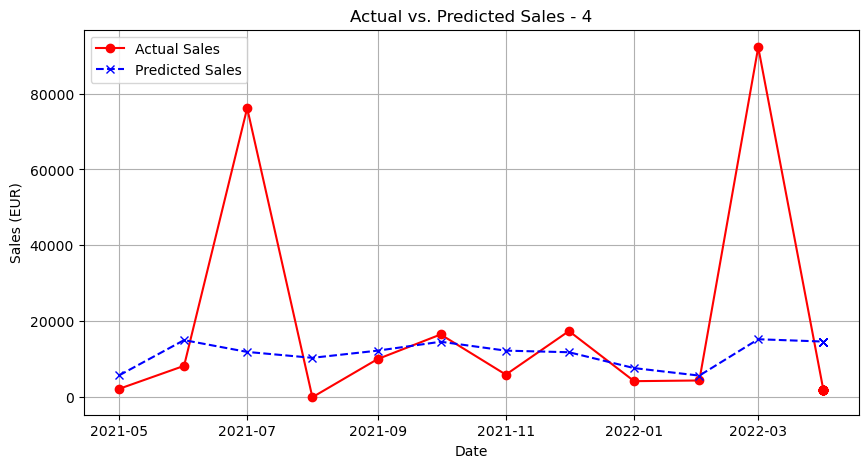

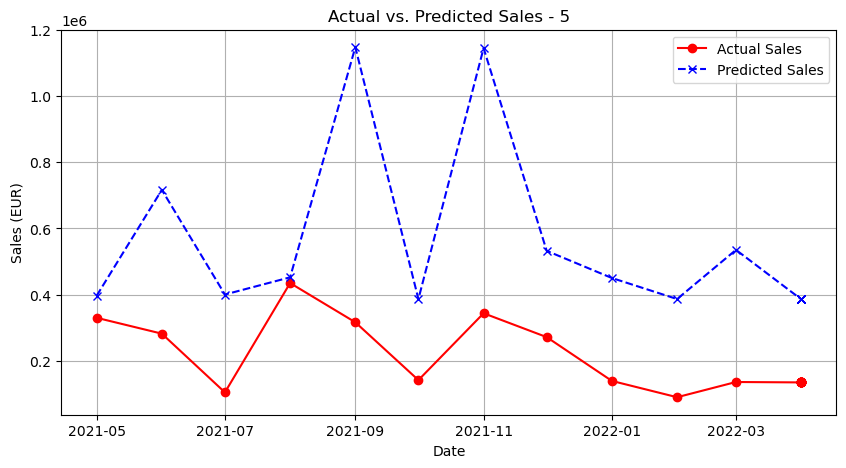

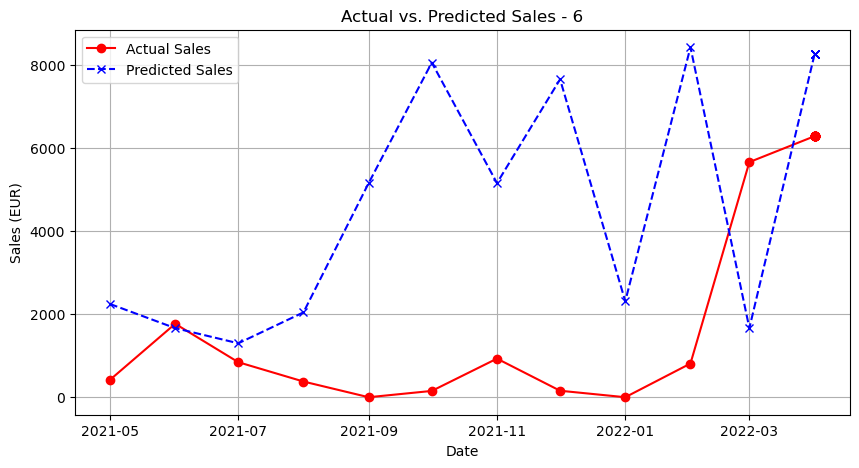

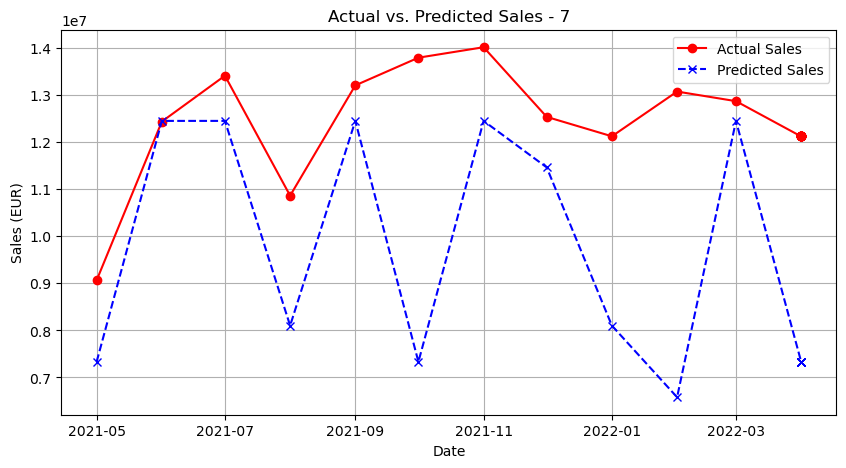

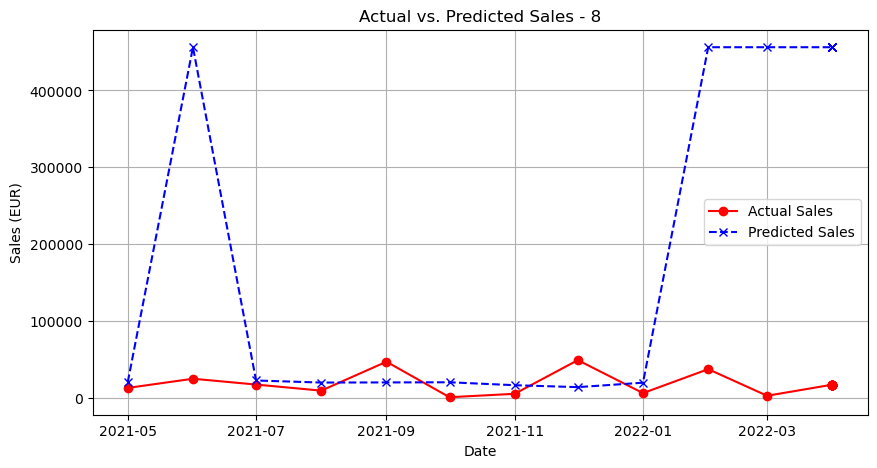

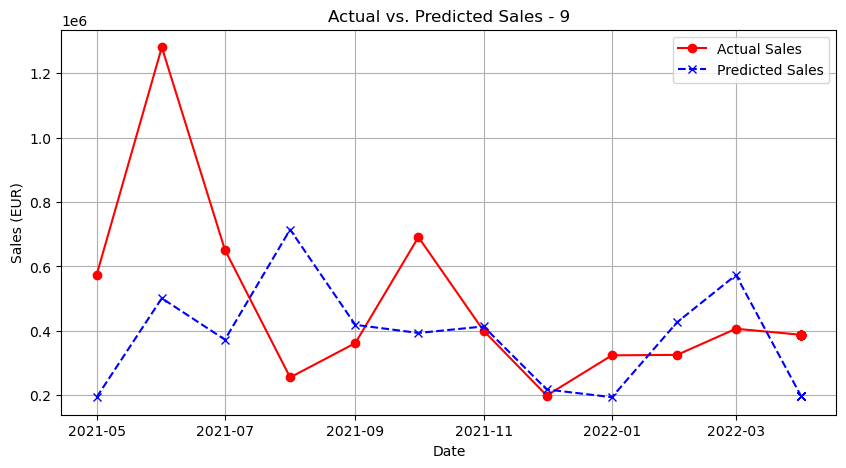

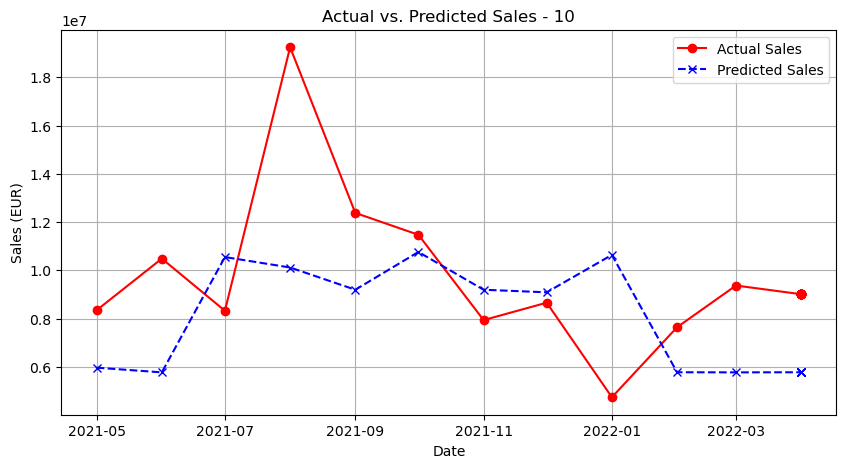

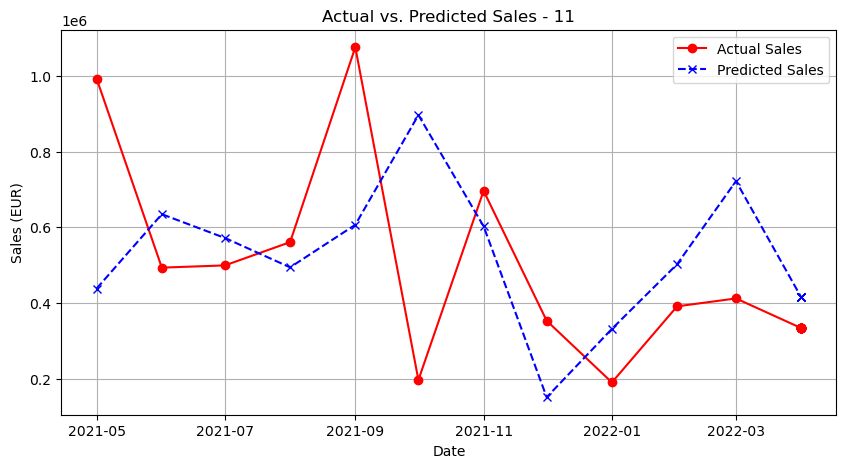

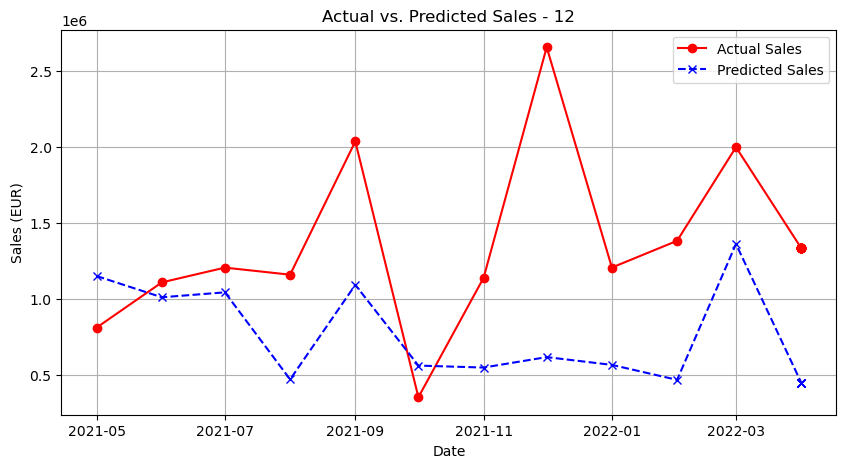

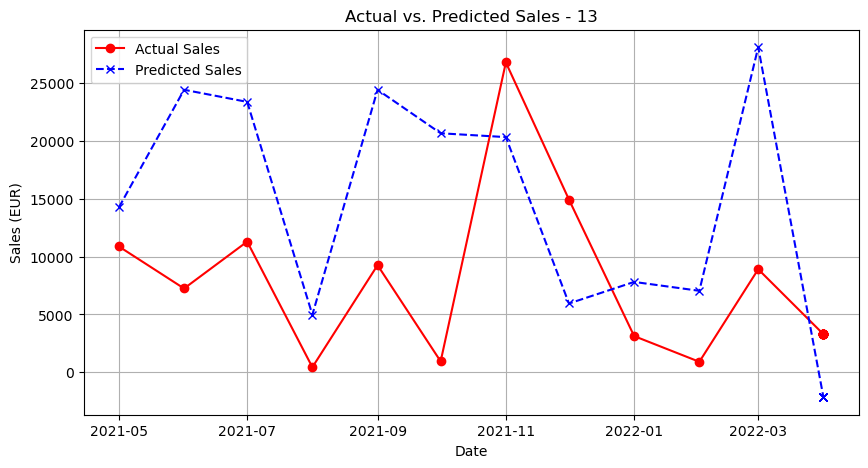

In [30]:
model_name = "XGBoost"
forecast = {}


for product in df['Mapped_GCK'].unique():
    product_df = df[df['Mapped_GCK'] == product]
    df_train = product_df[product_df['date'] < '2021-05-01']
    df_test = product_df[product_df['date'] >= '2021-05-01']
    
    # Use only the selected top features for this product
    top_features = top_features_per_product.get(product, [])
    
    X_train = df_train[top_features]
    y_train = df_train['Sales_EUR']
    X_test = df_test[top_features]
    y_test = df_test['Sales_EUR']
    
    # Train XGBoost model with selected features
    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric="rmse", n_estimators=100, random_state=1)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Store predictions
    forecast[product] = y_pred
    
    # Calculate RMSE
    rmse = root_mean_squared_error(y_test, y_pred)
    
    # Store RMSE under the model name
    if product not in rmse_results:
        rmse_results[product] = {}  # Create entry if not exists
    rmse_results[product][model_name] = rmse  # Store RMSE for this model
    
    plt.figure(figsize=(10, 5))
    plt.plot(df_test['date'], y_test, label="Actual Sales", marker="o", color = 'red')
    plt.plot(df_test['date'], y_pred, label="Predicted Sales", linestyle="dashed", marker="x" , color = 'blue')
    plt.xlabel("Date")
    plt.ylabel("Sales (EUR)")
    plt.title(f"Actual vs. Predicted Sales - {product}")
    plt.legend()
    plt.grid()
    plt.show()


XGBoost with grid search

In [31]:
model_name = "XGBoost_with_GridSearch"
grid_search_results = {}

param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],  
    'max_depth': [1, 2, 3, 5, 7, 6 ],            
    'learning_rate': [0.01, 0.1, 0,15, 0.2, 0.25, 0.3, 0.5],  
    'subsample': [0.8, 1.0 , 0.9],          
}

for product in df['Mapped_GCK'].unique():
    product_df = df[df['Mapped_GCK'] == product]
    df_train = product_df[product_df['date'] < '2021-05-01']
    df_test = product_df[product_df['date'] >= '2021-05-01']
    
    # Use only the selected top features for this product
    top_features = top_features_per_product.get(product, [])
    
    X_train = df_train[top_features]
    y_train = df_train['Sales_EUR']
    
    # Perform Grid Search
    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric="rmse", random_state=1)
    grid_search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get best parameters and RMSE
    best_params = grid_search.best_params_
    best_rmse = -grid_search.best_score_
    
    # Store best parameters and RMSE for each product
    grid_search_results[product] = {'best_rmse': best_rmse, 'best_params': best_params}


In [32]:
grid_search_results

{0: {'best_rmse': 4489807.57235985,
  'best_params': {'learning_rate': 0.2,
   'max_depth': 3,
   'n_estimators': 100,
   'subsample': 1.0}},
 1: {'best_rmse': 985039.0831466604,
  'best_params': {'learning_rate': 0.5,
   'max_depth': 3,
   'n_estimators': 50,
   'subsample': 0.8}},
 2: {'best_rmse': 123009.55437814452,
  'best_params': {'learning_rate': 0.01,
   'max_depth': 3,
   'n_estimators': 300,
   'subsample': 0.9}},
 3: {'best_rmse': 23197.443271918175,
  'best_params': {'learning_rate': 0.01,
   'max_depth': 5,
   'n_estimators': 50,
   'subsample': 1.0}},
 4: {'best_rmse': 11286.171032351378,
  'best_params': {'learning_rate': 0.01,
   'max_depth': 7,
   'n_estimators': 100,
   'subsample': 1.0}},
 5: {'best_rmse': 475913.34079273866,
  'best_params': {'learning_rate': 0.2,
   'max_depth': 1,
   'n_estimators': 500,
   'subsample': 0.9}},
 6: {'best_rmse': 1596.5552850107638,
  'best_params': {'learning_rate': 0.01,
   'max_depth': 5,
   'n_estimators': 400,
   'subsample': 

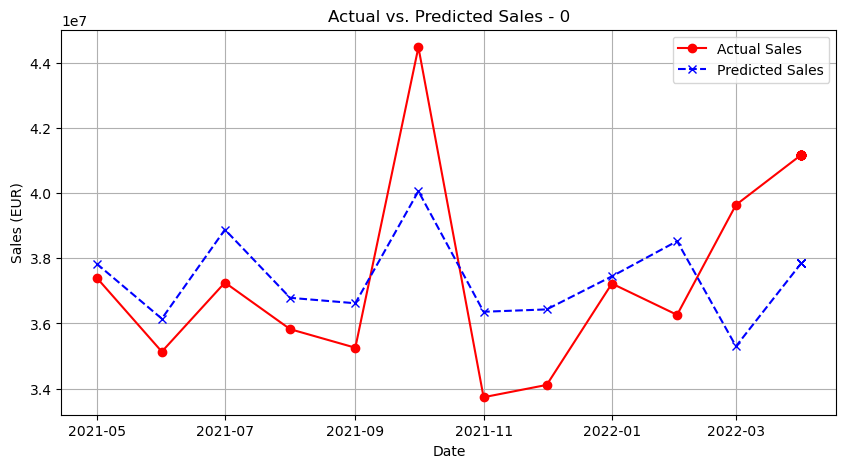

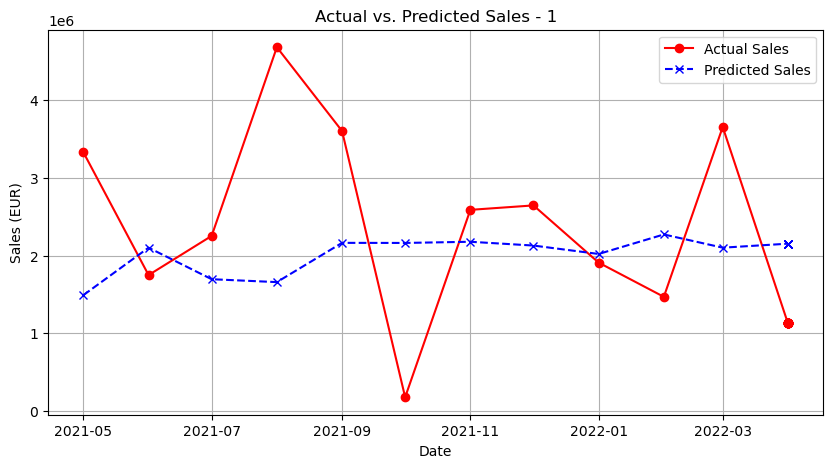

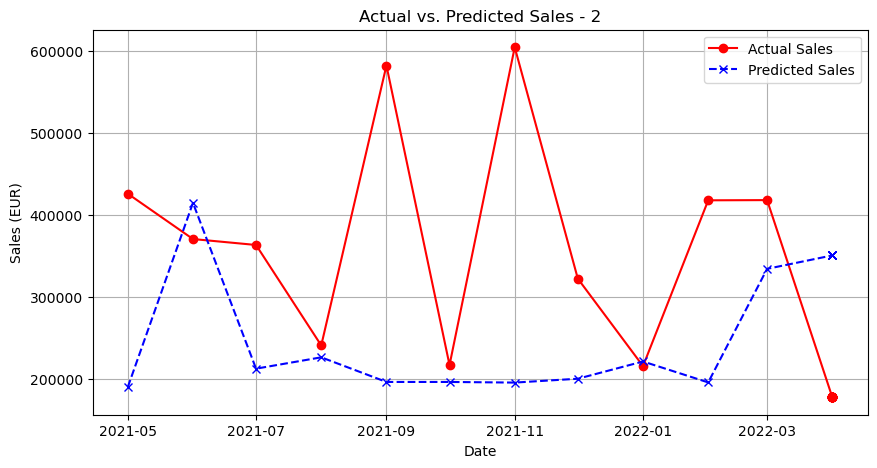

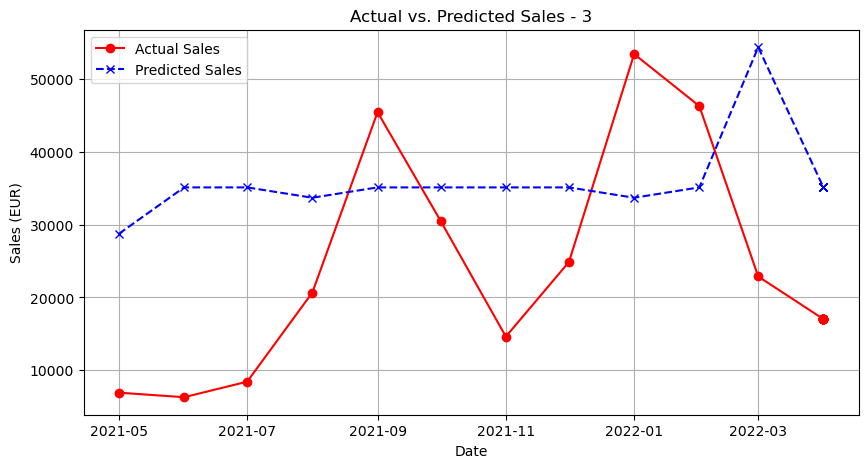

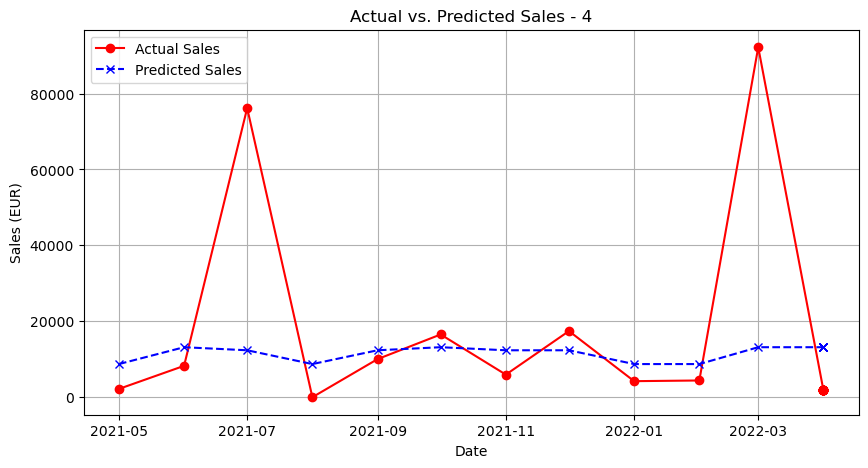

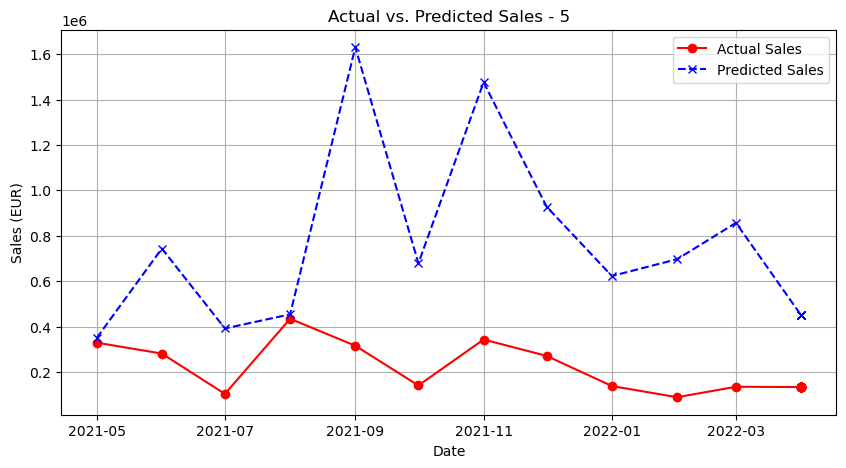

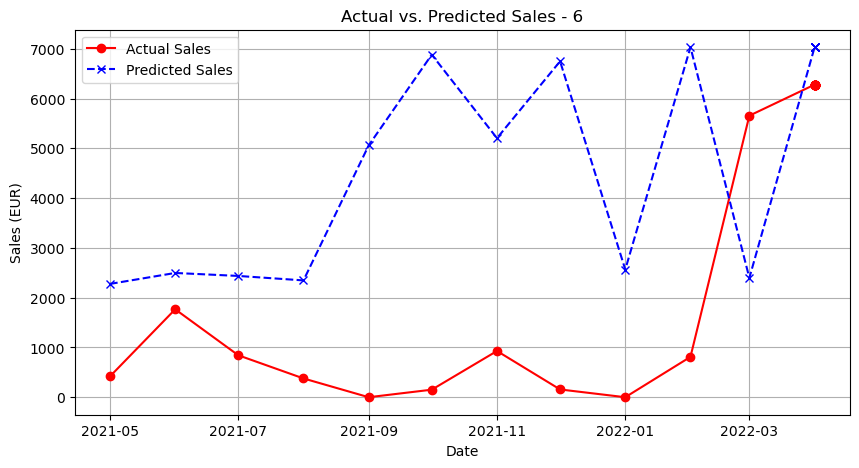

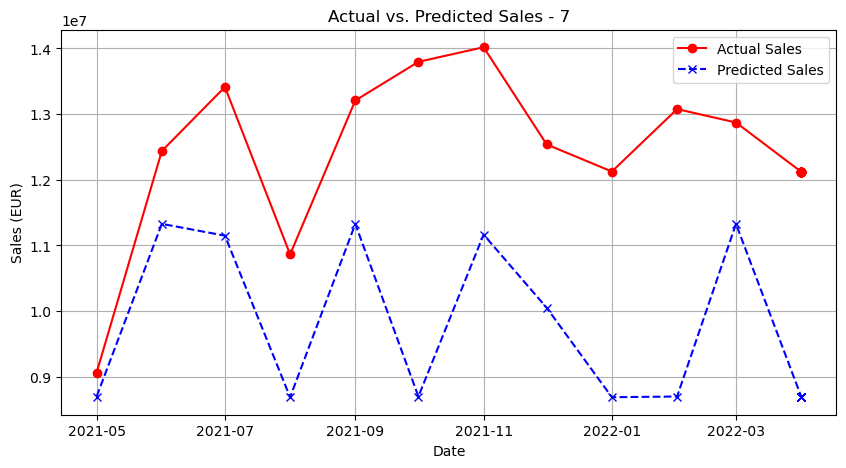

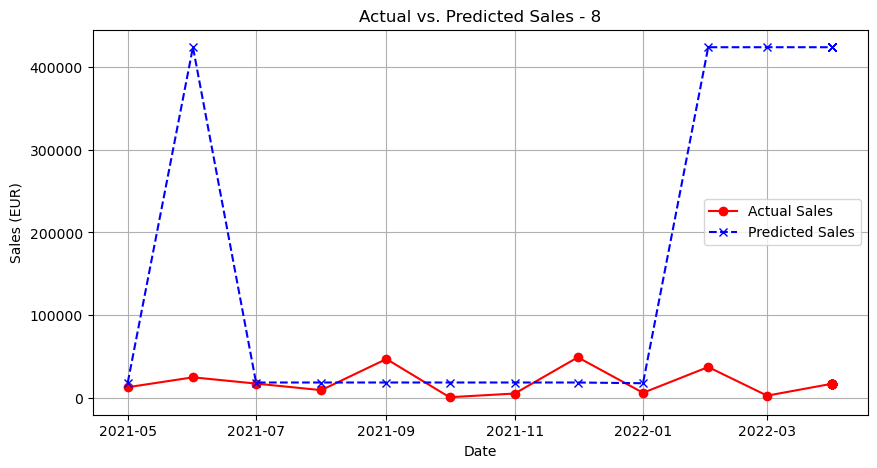

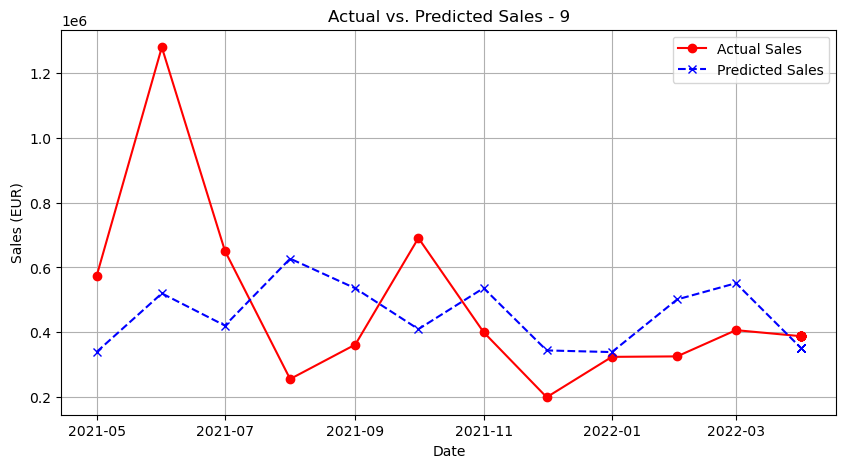

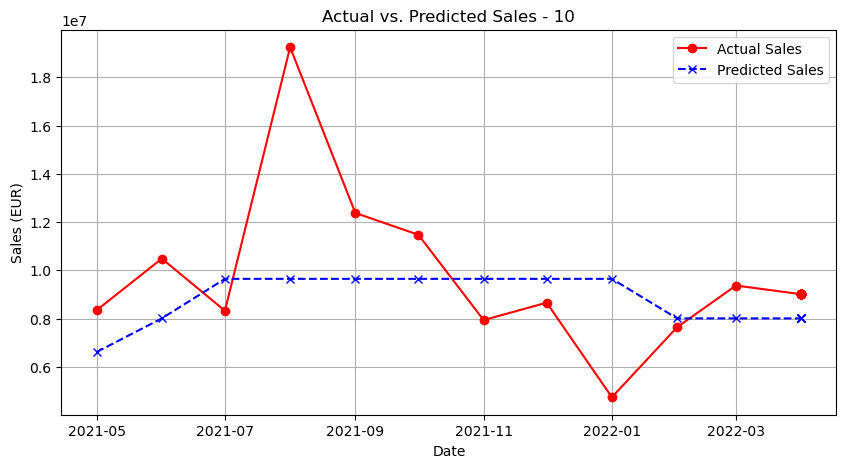

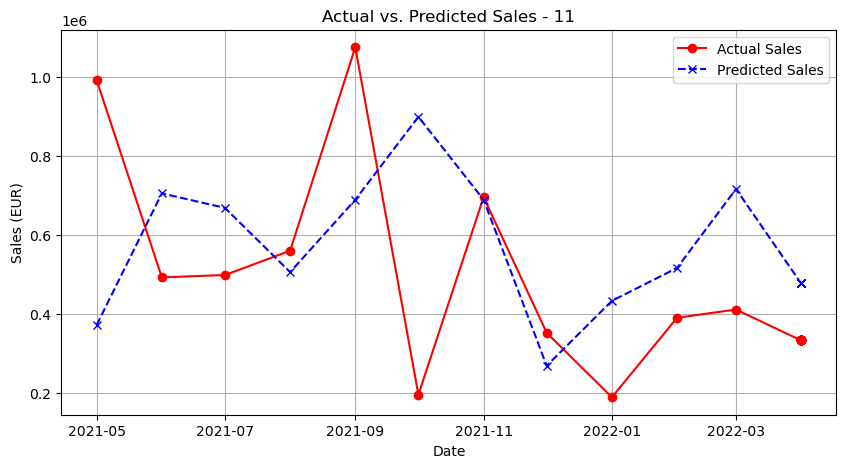

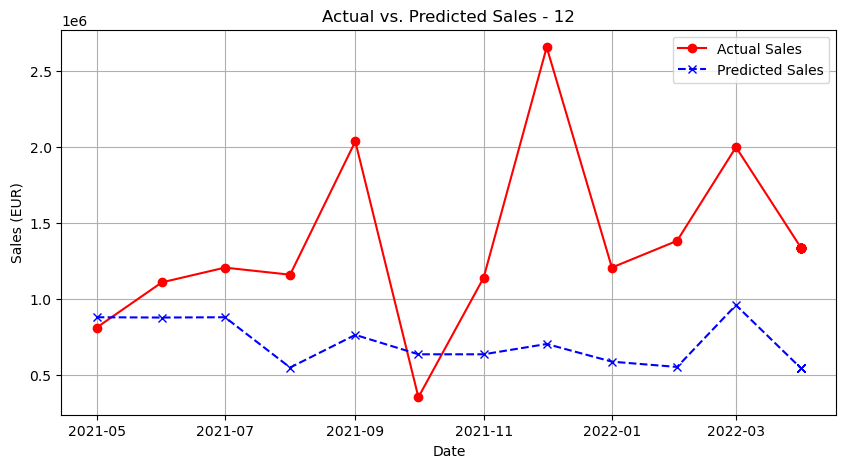

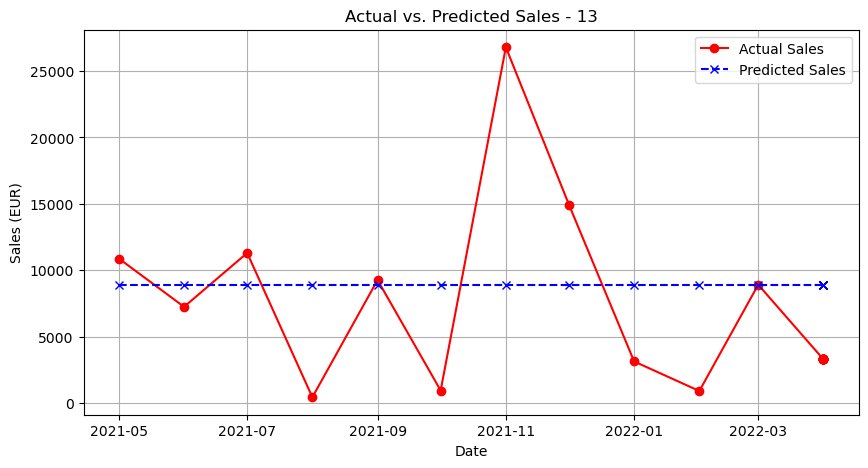

In [33]:
model_name = "XGBoost_with_GridSearch"
forecast = {}

for product in df['Mapped_GCK'].unique():
    product_df = df[df['Mapped_GCK'] == product]
    df_train = product_df[product_df['date'] < '2021-05-01']
    df_test = product_df[product_df['date'] >= '2021-05-01']
    
    # Use only the selected top features for this product
    top_features = top_features_per_product.get(product, [])
    
    X_train = df_train[top_features]
    y_train = df_train['Sales_EUR']
    X_test = df_test[top_features]
    y_test = df_test['Sales_EUR']
    
    # Retrieve best parameters for this product
    best_params = grid_search_results.get(product, {}).get('best_params', {})

    
    # Train XGBoost model with selected features and best parameters
    model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        eval_metric="rmse", 
        random_state=1,
        **best_params  # Unpack best parameters
    )
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Store predictions
    forecast[product] = y_pred
    
    # Calculate RMSE
    rmse = root_mean_squared_error(y_test, y_pred)
    
    # Store RMSE under the model name
    if product not in rmse_results:
        rmse_results[product] = {}  # Create entry if not exists
    rmse_results[product][model_name] = rmse  # Store RMSE for this model
    
    plt.figure(figsize=(10, 5))
    plt.plot(df_test['date'], y_test, label="Actual Sales", marker="o", color='red')
    plt.plot(df_test['date'], y_pred, label="Predicted Sales", linestyle="dashed", marker="x", color='blue')
    plt.xlabel("Date")
    plt.ylabel("Sales (EUR)")
    plt.title(f"Actual vs. Predicted Sales - {product}")
    plt.legend()
    plt.grid()
    plt.show()



In [34]:
rmse_results

{0: {'Prophet_vanila': 4765012.155207862,
  'Prophet_with_features': 39722658.04398702,
  'XGBoost': 2008353.3100930313,
  'XGBoost_with_GridSearch': 2979859.6496548476},
 1: {'Prophet_vanila': 1469030.5677702597,
  'Prophet_with_features': 5209426.855683226,
  'XGBoost': 1241389.066081013,
  'XGBoost_with_GridSearch': 1207736.3929657266},
 2: {'Prophet_vanila': 342064.54343881964,
  'Prophet_with_features': 3048698.324498198,
  'XGBoost': 177492.00781092848,
  'XGBoost_with_GridSearch': 187156.5653910662},
 3: {'Prophet_vanila': 24759.261680468364,
  'Prophet_with_features': 595198.7118918371,
  'XGBoost': 28602.165918937244,
  'XGBoost_with_GridSearch': 18851.019093183895},
 4: {'Prophet_vanila': 23669.71699364573,
  'Prophet_with_features': 63394.6254593793,
  'XGBoost': 21884.306738913747,
  'XGBoost_with_GridSearch': 21631.52255534193},
 5: {'Prophet_vanila': 365113.55770673166,
  'Prophet_with_features': 1236273.1095607083,
  'XGBoost': 339028.86545673665,
  'XGBoost_with_GridSea

## Linear Regression

Without features

With features

In [35]:
df_model.dtypes

Mapped_GCK                         int32
Sales_EUR                        float64
date                      datetime64[ns]
MAB_ELE_PRO156                   float64
MAB_ELE_SHP156                   float64
MAB_ELE_PRO250                   float64
MAB_ELE_SHP250                   float64
MAB_ELE_PRO276                   float64
MAB_ELE_SHP276                   float64
MAB_ELE_PRO380                   float64
MAB_ELE_SHP380                   float64
MAB_ELE_PRO392                   float64
MAB_ELE_SHP392                   float64
MAB_ELE_PRO756                   float64
MAB_ELE_SHP756                   float64
MAB_ELE_PRO826                   float64
MAB_ELE_SHP826                   float64
MAB_ELE_PRO840                   float64
MAB_ELE_SHP840                   float64
MAB_ELE_PRO1100                  float64
MAB_ELE_SHP1100                  float64
RohiBASEMET1000_org              float64
RohiENERGY1000_org               float64
RohiMETMIN1000_org               float64
RohiNATGAS1000_o

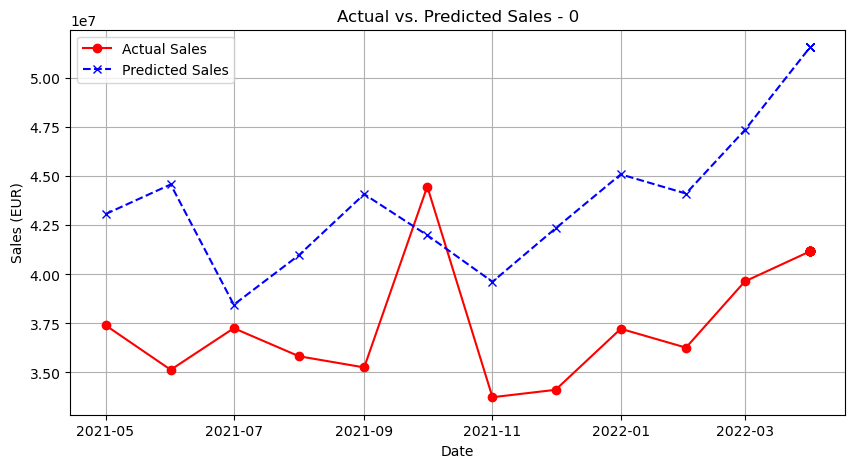

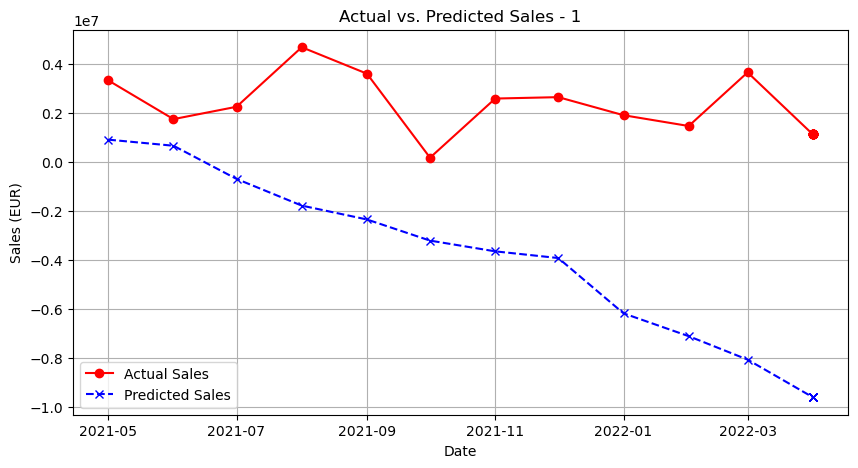

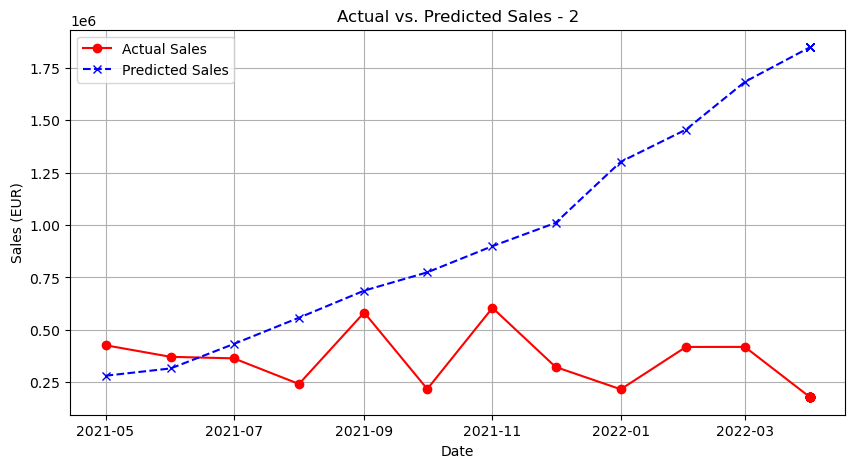

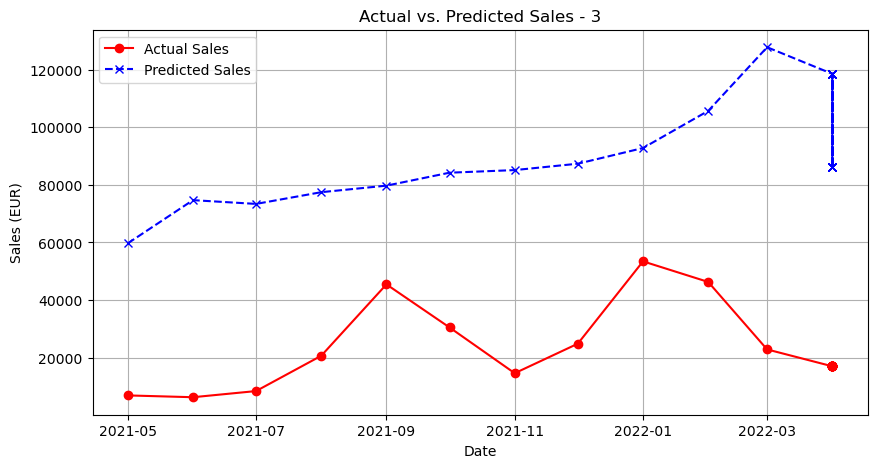

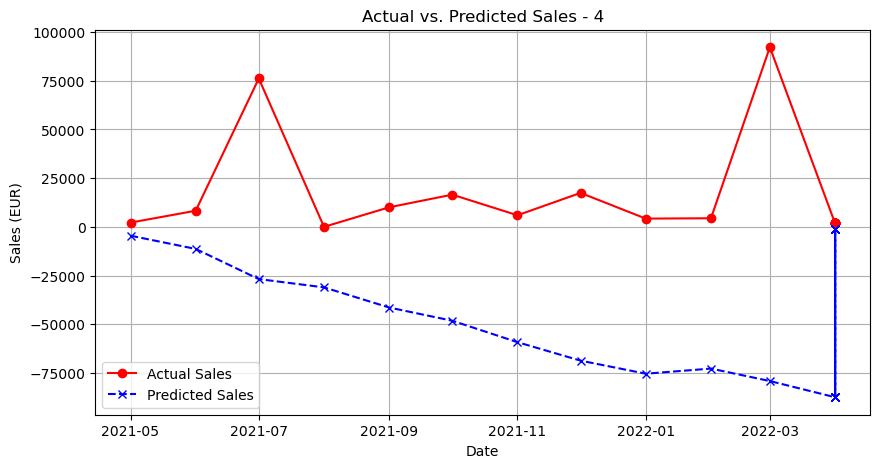

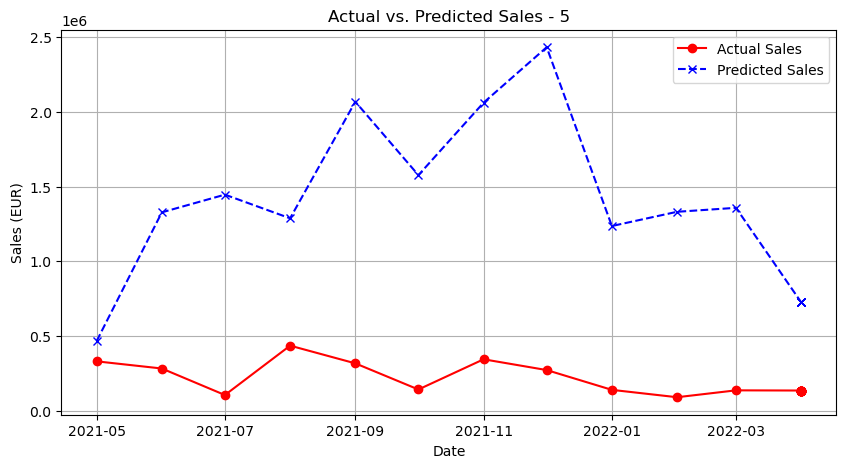

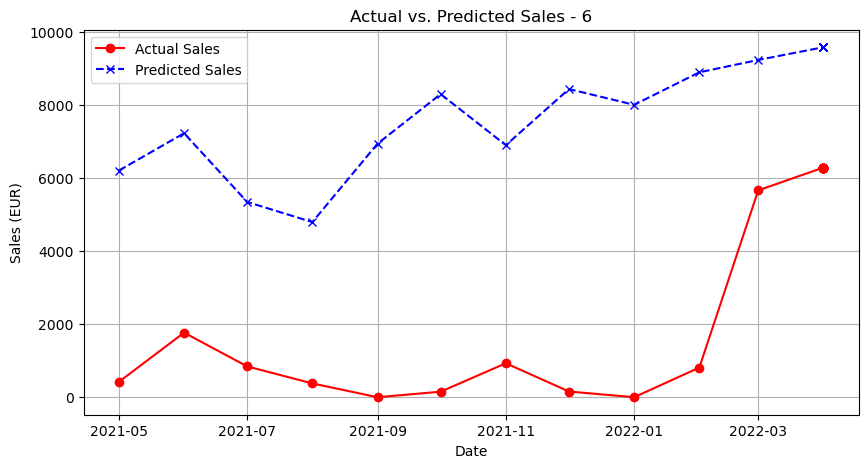

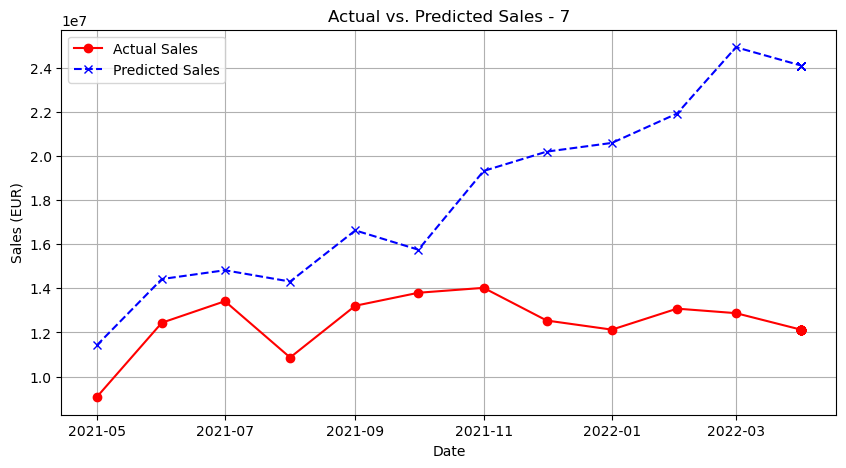

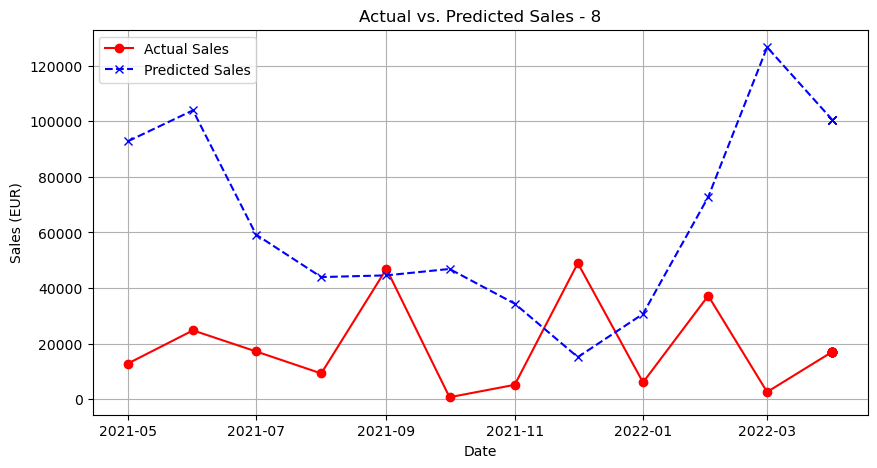

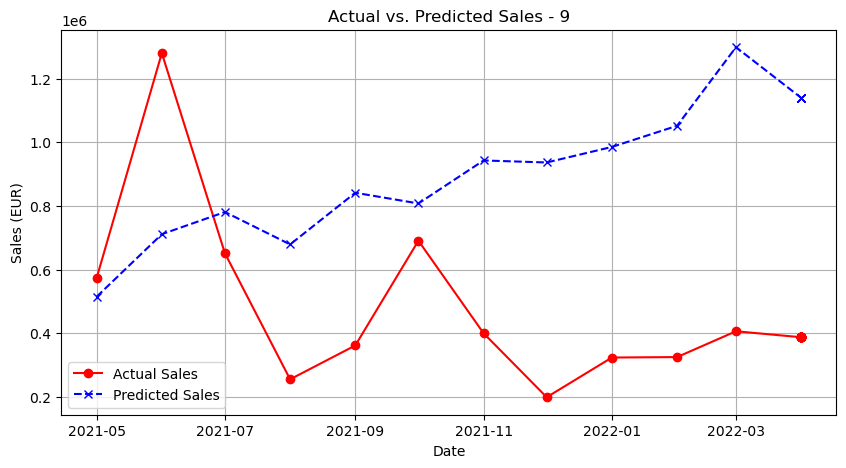

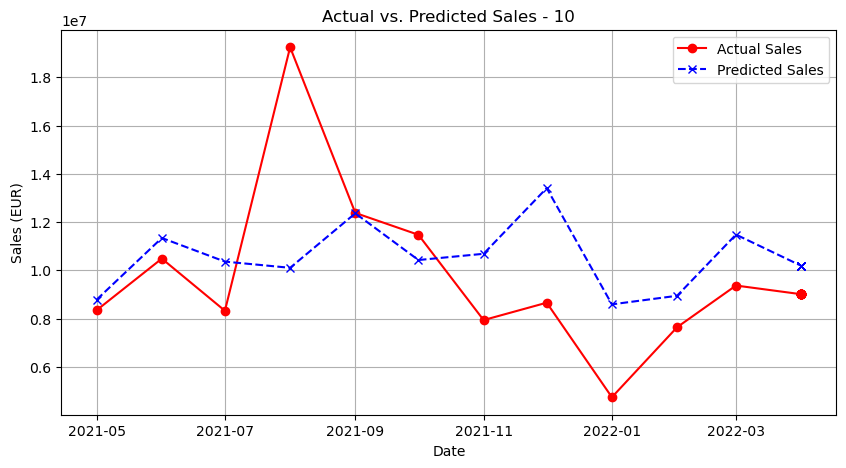

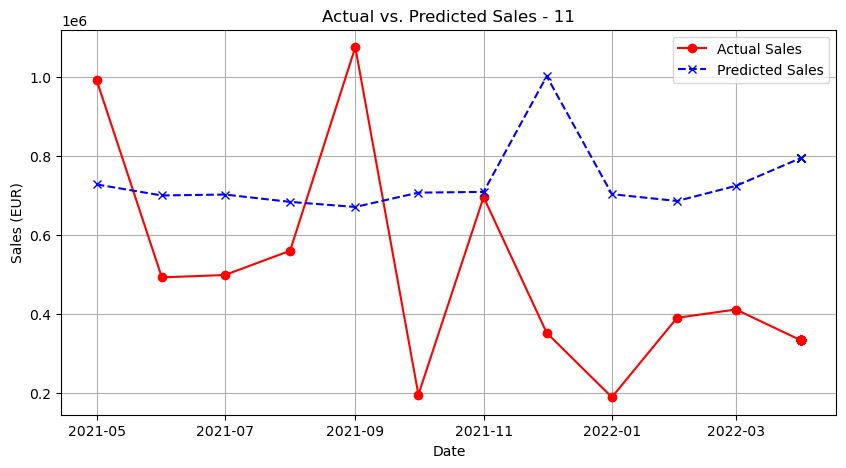

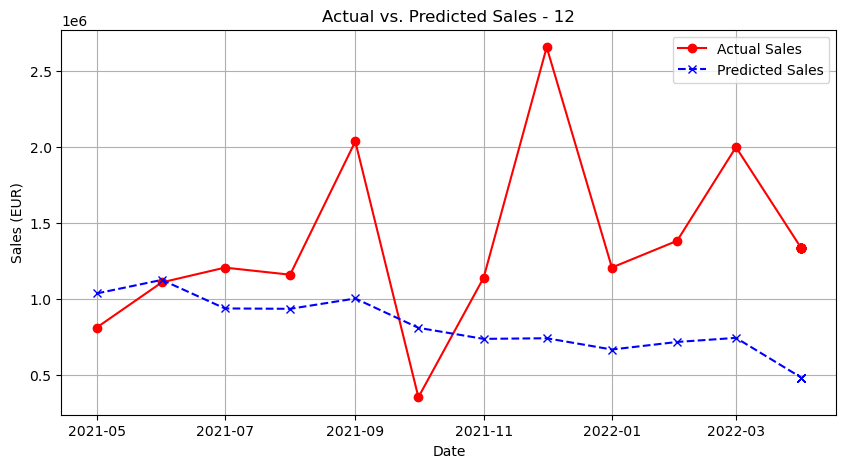

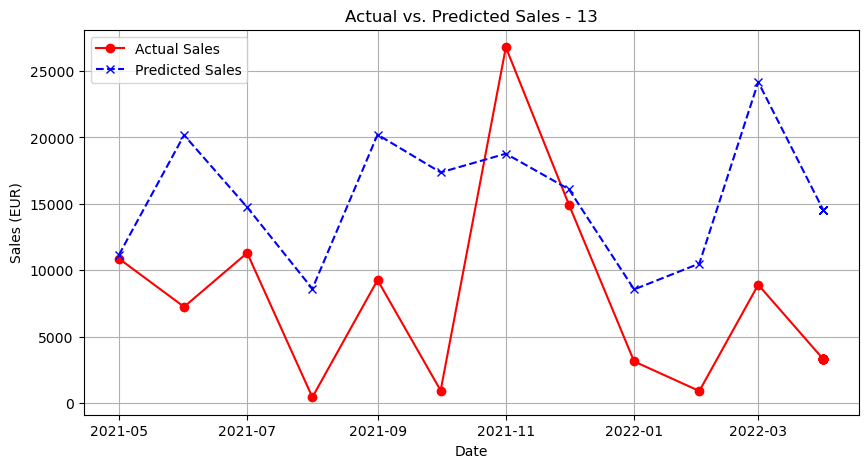

In [36]:
model_name = "Linear_Regression_with_features"
forecasts = {}


for product in df['Mapped_GCK'].unique():
    product_df = df[df['Mapped_GCK'] == product]
    df_train = product_df[product_df['date'] < '2021-05-01']
    df_test = product_df[product_df['date'] >= '2021-05-01']
    
    # Use only the selected top features for this product
    top_features = top_features_per_product.get(product, [])
    
    X_train = df_train[top_features]
    y_train = df_train['Sales_EUR']
    X_test = df_test[top_features]
    y_test = df_test['Sales_EUR']
    
    # Train XGBoost model with selected features
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Store predictions
    forecast[product] = y_pred
    
    # Calculate RMSE
    rmse = root_mean_squared_error(y_test, y_pred)
    
    # Store RMSE under the model name
    if product not in rmse_results:
        rmse_results[product] = {}  # Create entry if not exists
    rmse_results[product][model_name] = rmse  # Store RMSE for this model
    
    plt.figure(figsize=(10, 5))
    plt.plot(df_test['date'], y_test, label="Actual Sales", marker="o", color = 'red')
    plt.plot(df_test['date'], y_pred, label="Predicted Sales", linestyle="dashed", marker="x" , color = 'blue')
    plt.xlabel("Date")
    plt.ylabel("Sales (EUR)")
    plt.title(f"Actual vs. Predicted Sales - {product}")
    plt.legend()
    plt.grid()
    plt.show()


In [37]:
rmse_results

{0: {'Prophet_vanila': 4765012.155207862,
  'Prophet_with_features': 39722658.04398702,
  'XGBoost': 2008353.3100930313,
  'XGBoost_with_GridSearch': 2979859.6496548476,
  'Linear_Regression_with_features': 9136688.1789602},
 1: {'Prophet_vanila': 1469030.5677702597,
  'Prophet_with_features': 5209426.855683226,
  'XGBoost': 1241389.066081013,
  'XGBoost_with_GridSearch': 1207736.3929657266,
  'Linear_Regression_with_features': 9242004.465798987},
 2: {'Prophet_vanila': 342064.54343881964,
  'Prophet_with_features': 3048698.324498198,
  'XGBoost': 177492.00781092848,
  'XGBoost_with_GridSearch': 187156.5653910662,
  'Linear_Regression_with_features': 1354224.9716806877},
 3: {'Prophet_vanila': 24759.261680468364,
  'Prophet_with_features': 595198.7118918371,
  'XGBoost': 28602.165918937244,
  'XGBoost_with_GridSearch': 18851.019093183895,
  'Linear_Regression_with_features': 78052.08883097509},
 4: {'Prophet_vanila': 23669.71699364573,
  'Prophet_with_features': 63394.6254593793,
  'XG